<a href="https://colab.research.google.com/github/Faosiya/AN-INVESTIGATION-INTO-FITNESS-DATA-FOR-TRIVIOSO-S-NEW-FITNESS-TRACKING-DEVICE/blob/main/A%26E_WAITING_MODELLING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MATHEMATICAL MODELLING OF ACCIDENT AND EMERGENCY DEPARTMENT DATASET**

In [1]:
#Importing all necessary packages
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import datetime, timedelta
from scipy.stats import gamma
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Set the directory to your folder
directory = '/content/drive/My Drive/A&E_dataset'

# Path to the CSV file containing the patient visit table
csv_file_path_v = os.path.join(directory, 'database_visits.csv')

#df = pd.read_csv(csv_file_path_v)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# @title Import the Patient Visit Data

# Read the CSV file containing the patient visit details into a DataFrame
df = pd.read_csv(csv_file_path_v)

# Display the first few rows of the DataFrame
#df_patient.head()

In [4]:
#print(df.info())
#print(df.head())

In [5]:
# @title **Data Wrangling**
#Converting all date columns to the appropriate format
df = df.copy()

#Conversion to datetime
df['entry_date'] = pd.to_datetime(df['entry_date'])
df['hospitalization_date'] = pd.to_datetime(df['hospitalization_date'], errors='coerce')
df['exit_date'] = pd.to_datetime(df['exit_date'], errors='coerce')

#filtered and convert to timedelta
df = df[(df["entry_group"] == 1)]
df['ED_dur'] = pd.to_timedelta(df['ED_dur'],'s')
df["exit_ED"] = df["entry_date"] + df["ED_dur"]

# Sorting entry_date in ascending order
df = df.sort_values(by="entry_date", ascending=True)

# Reset the index
df.reset_index(drop=True, inplace=True)

# Display the first few rows of the sorted DataFrame
#df.head()

In [6]:
# Saving the selected columns into a new DataFrame
df1 = df.copy()

# Displaying the first few rows of the new DataFrame with selected columns
#df1.head()

# ***OBTAINING A&E QUEUE LENGTH***

In [7]:
# Read the CSV files into DataFrames
csv_path1 = os.path.join(directory, 'num_in_ed_df.csv')
num_in_ed = pd.read_csv(csv_path1)

csv_path2 = os.path.join(directory, 'hourly_minutes_df.csv')
hourly_minutes = pd.read_csv(csv_path2)

csv_path3 = os.path.join(directory, 'frequency1_df.csv')
frequency1 = pd.read_csv(csv_path3)

# Print a few entries to verify the import
print("num_in_ed:", num_in_ed.head())
print("frequency1:", frequency1.head())
print("hourly_minutes:", hourly_minutes.head())



num_in_ed:    num_in_ed
0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
frequency1:    Unnamed: 0                                             values  \
0           0  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 1...   
1           1  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 1...   
2           2  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 1...   
3           3  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 1...   
4           4  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 1...   

                                              counts       mean  
0  [   0.    9.   10.   59.   36.   34.   74.  14...  34.648455  
1  [0.000e+00 1.100e+01 2.000e+01 2.400e+01 2.400...  30.602583  
2  [0.000e+00 0.000e+00 0.000e+00 2.300e+01 5.300...  26.064310  
3  [0.000e+00 0.000e+00 0.000e+00 3.500e+01 6.400...  23.075345  
4  [   0.    0.    0.    0.   82.   67.  133.  41...  21.932024  
hourly_minutes:      0     1     2     3     4     5     6     7     8     9  ...    14    15 

In [8]:
# @title Read back the saved files into DataFrames

# Load num_in_ed from JSON
with open(os.path.join(directory, 'num_in_ed.json'), 'r') as f:
    num_in_ed_dict = json.load(f)
num_in_ed = np.array(num_in_ed_dict['num_in_ed'])

# Load hourly_minutes from JSON
with open(os.path.join(directory, 'hourly_minutes.json'), 'r') as f:
    hourly_minutes = json.load(f)

# Load frequency1 from JSON
with open(os.path.join(directory, 'frequency1.json'), 'r') as f:
    frequency1 = json.load(f)

#Print a few entries to verify the import
#print("num_in_ed:", num_in_ed[:10])  # Print the first 10 entries
#print("frequency1:", {k: frequency1[k] for k in list(frequency1)[:3]})  # Print the first 3 hours
print("hourly_minutes:", {k: hourly_minutes[k][:10] for k in list(hourly_minutes)[:3]})  # Print the first 10 entries for the first 3 hours


hourly_minutes: {'0': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0], '1': [12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 14.0, 14.0, 14.0], '2': [13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 12.0, 12.0, 12.0]}


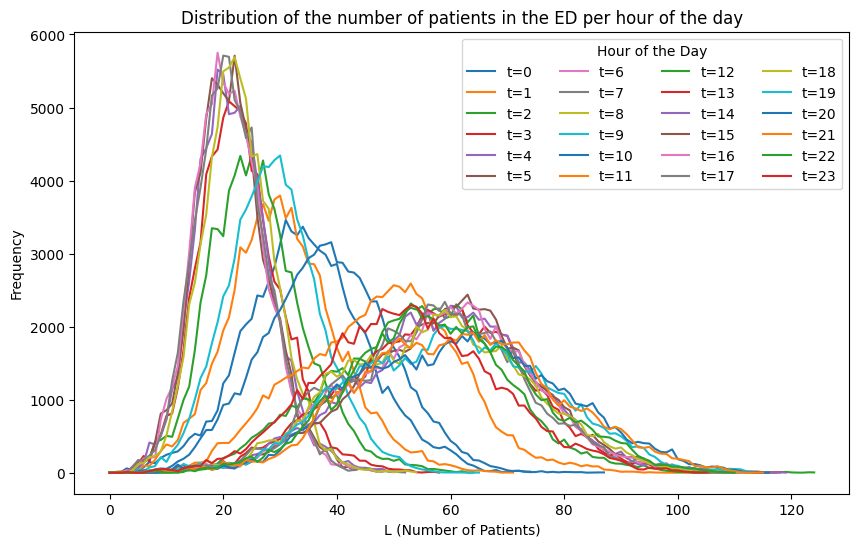

In [9]:
# @title Line Plot of the distribution of patients per hour of the day

# Load num_in_ed from JSON
with open(os.path.join(directory, 'num_in_ed.json'), 'r') as f:
    num_in_ed_dict = json.load(f)
num_in_ed = np.array(num_in_ed_dict['num_in_ed'])

# Load hourly_minutes from JSON
with open(os.path.join(directory, 'hourly_minutes.json'), 'r') as f:
    hourly_minutes = json.load(f)

# Load frequency1 from JSON
with open(os.path.join(directory, 'frequency1.json'), 'r') as f:
    frequency1 = json.load(f)

# Plot the distribution of patients per hour of the day
plt.figure(figsize=(10, 6))

# Ensure keys are treated as strings when accessing JSON data
for hour in range(24):
    hour_str = str(hour)
    values = np.array(frequency1[hour_str]['values'])
    counts = np.array(frequency1[hour_str]['counts'])
    plt.plot(values, counts, label=f't={hour}')

plt.xlabel('L (Number of Patients)')
plt.ylabel('Frequency')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), title='Hour of the Day', ncol=4)
plt.title('Distribution of the number of patients in the ED per hour of the day')
#plt.grid(True)
plt.show()


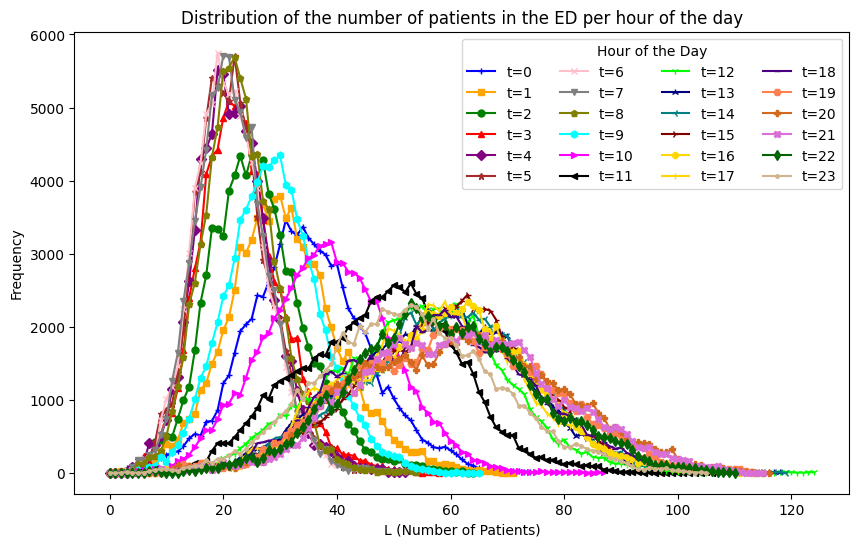

In [10]:
# @title Line Plot of the distribution of patients per hour of the day

# List of markers for each hour
markers = ['+', 's', 'o', '^', 'D', '*', 'x', 'v', 'p', 'h', '>', '<', '1', '2', '3', '4', '8', '|', '_', 'H', 'P', 'X', 'd', '.']
colors = [
    'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'black',
    'lime', 'navy', 'teal', 'maroon', 'gold', 'gold', 'indigo', 'coral', 'chocolate', 'orchid', 'darkgreen', 'tan'
]

# Define marker size
marker_size = 5

# Plot the distribution of patients per hour of the day
plt.figure(figsize=(10, 6))

# Ensure keys are treated as strings when accessing JSON data
for hour in range(24):
    hour_str = str(hour)
    if hour_str in frequency1:
        values = np.array(frequency1[hour_str]['values'])
        counts = np.array(frequency1[hour_str]['counts'])
        plt.plot(values, counts, label=f't={hour}', marker=markers[hour], color=colors[hour], markersize=marker_size)

plt.xlabel('L (Number of Patients)')
plt.ylabel('Frequency')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1), title='Hour of the Day', ncol=4)
plt.title('Distribution of the number of patients in the ED per hour of the day')
# plt.grid(True)
plt.show()


# ***Fitting and Extracting the Gamma Distribution Parameter***

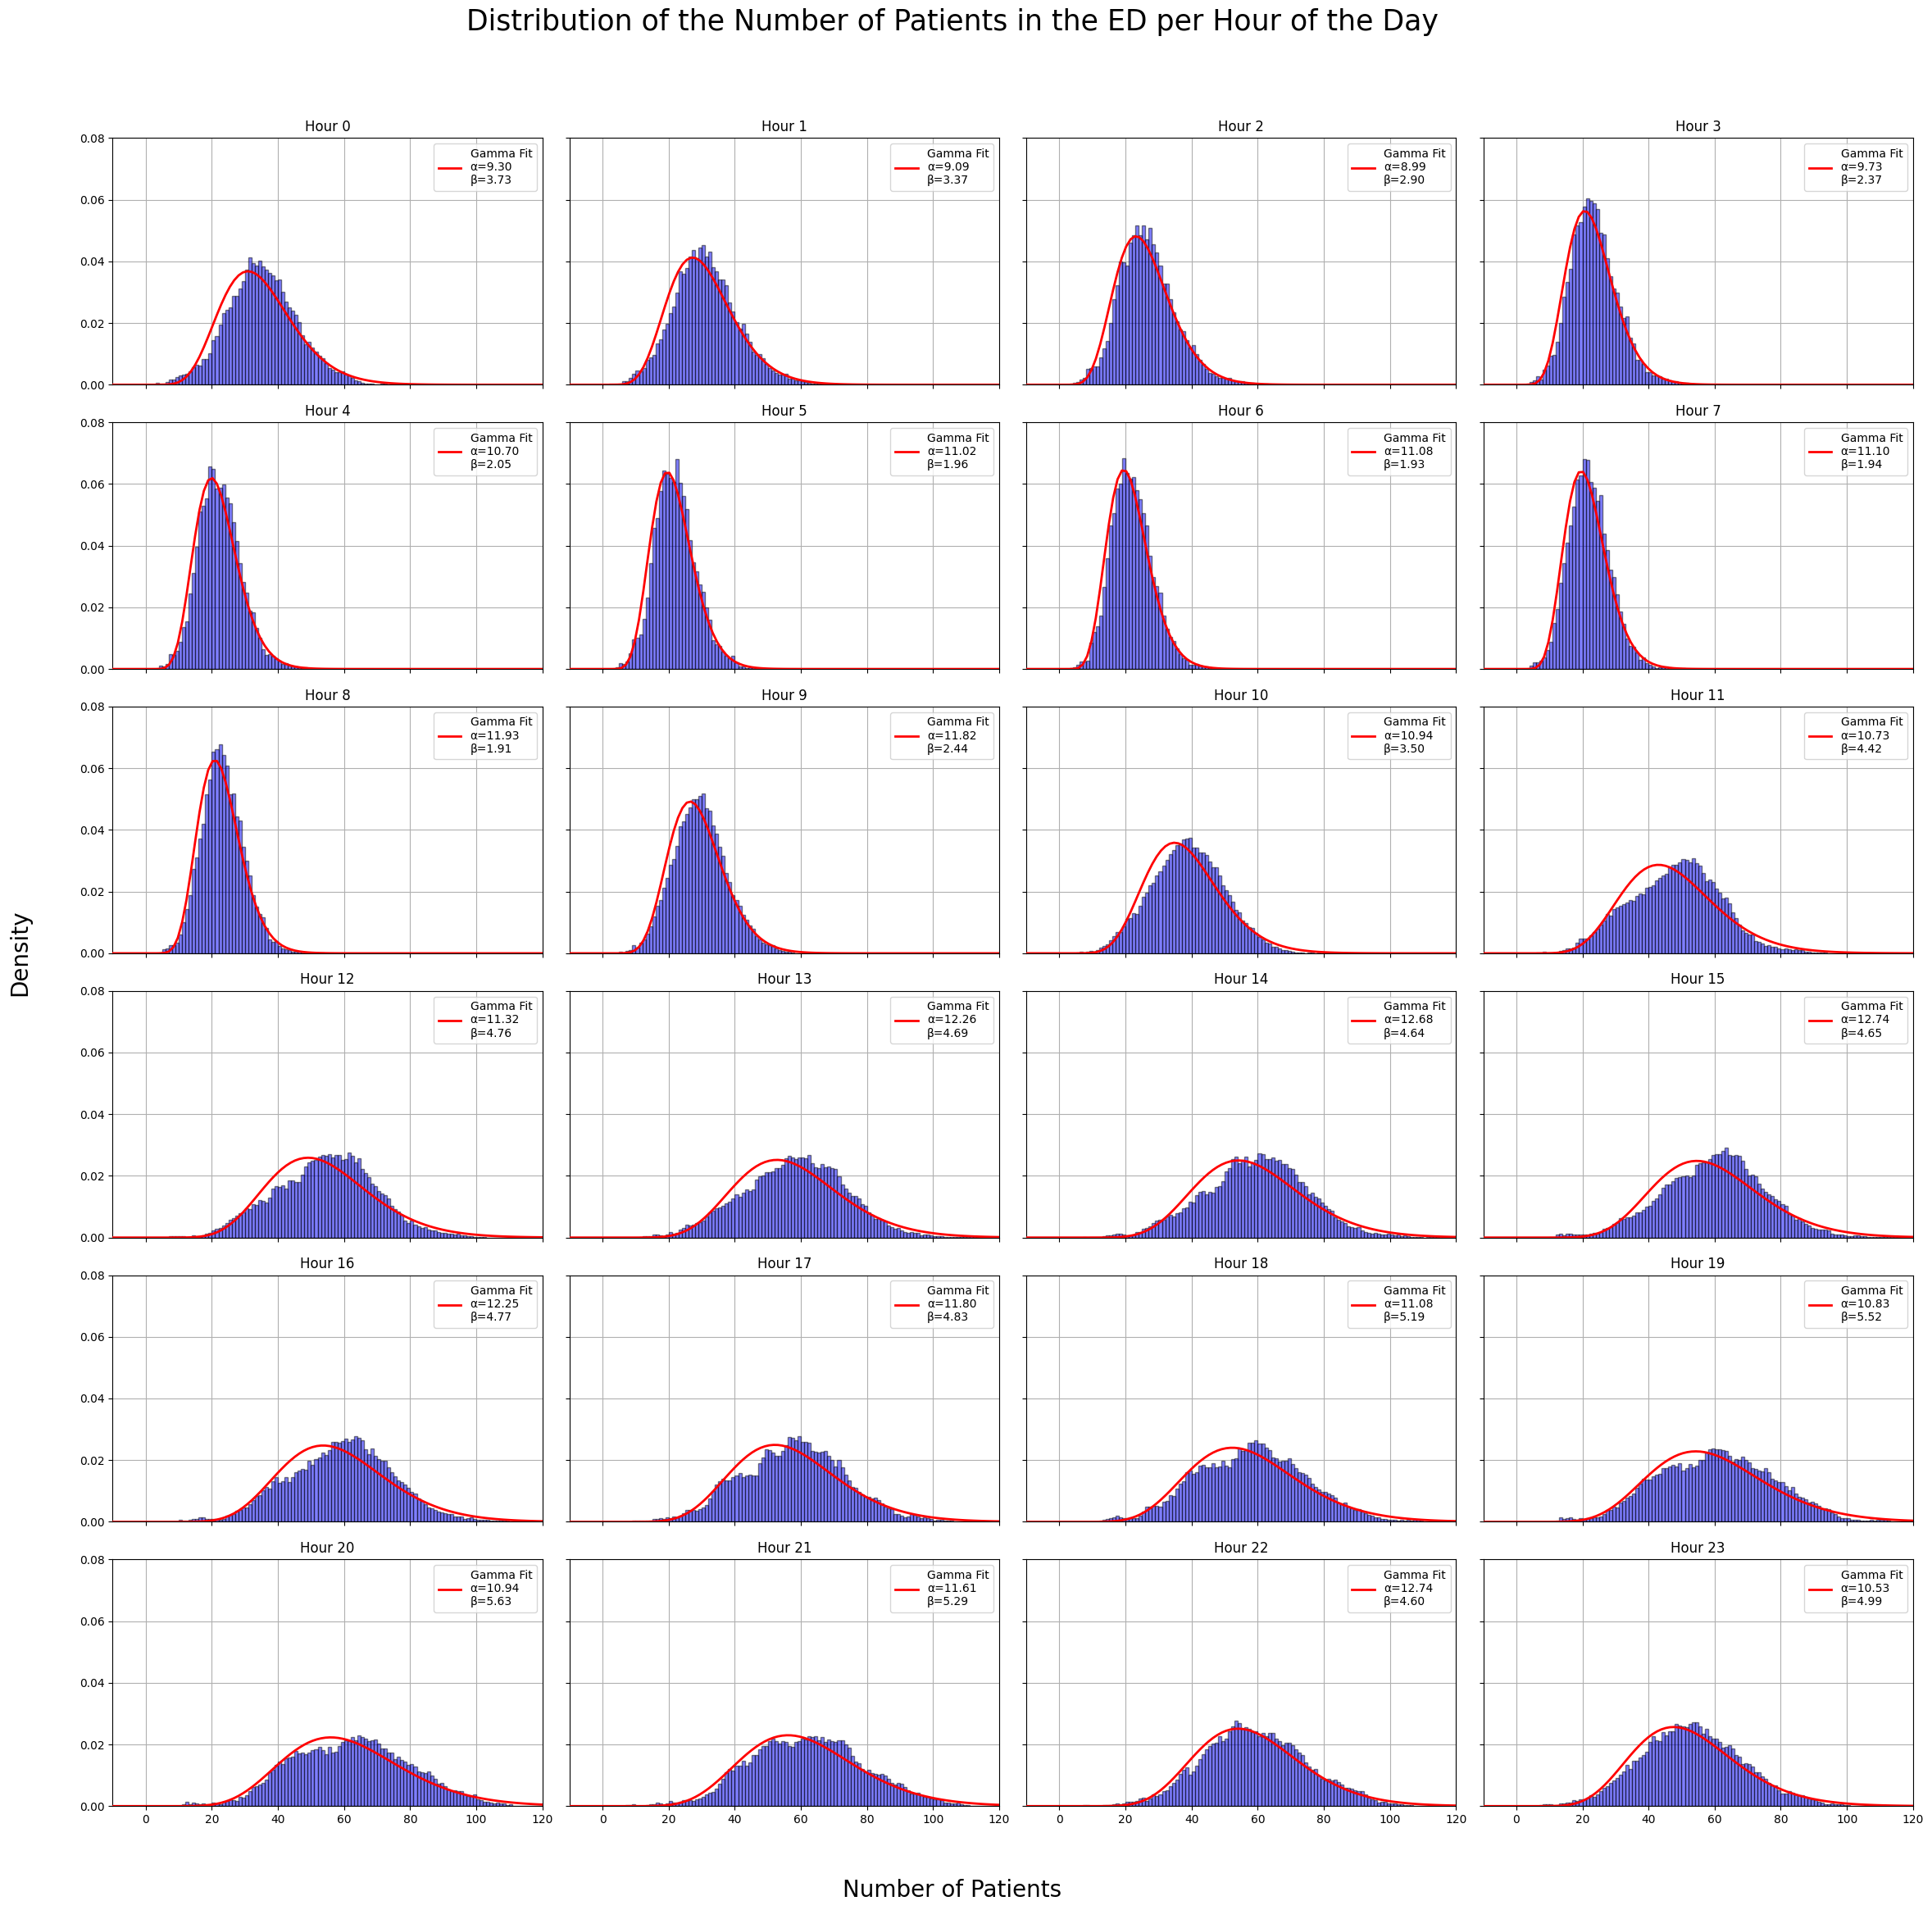

In [11]:
# @title **Fitting and Extracting the Gamma Distribution Parameter**

# Initialize lists to hold alpha and beta parameters for each hour
alpha_params = []
beta_params = []

# Set extended x-axis limits
x_min, x_max = -10, 120  # Adjusted range to zoom out

y_min, y_max = 0, 0.08
y_ticks = np.arange(y_min, y_max + 0.02, 0.02)

# Plot the distribution of the number of patients in the ED per hour of the day and fit gamma distributions
fig, axes = plt.subplots(6, 4, figsize=(24, 24), sharex=True, sharey=True)  # Increased figure size

# Adjust space between subplots and between the title and the plots
plt.subplots_adjust(hspace=0.3, wspace=0.2)  # Increase space between subplots for better readability

for hour in range(24):
    row, col = divmod(hour, 4)

    # Access data for the current hour
    hourly_data = np.array(hourly_minutes[str(hour)])  # Convert list to NumPy array
    hourly_data = hourly_data[hourly_data > 0]  # Remove zero and negative values

    if len(hourly_data) > 10:  # Ensure sufficient data for fitting
        # Fit gamma distribution
        alpha, loc, beta = gamma.fit(hourly_data, floc=0)
        alpha_params.append(alpha)
        beta_params.append(beta)

        # Plot histogram
        counts, bins, _ = axes[row, col].hist(hourly_data, bins=np.arange(x_min, x_max + 1, 1), density=True, alpha=0.5, color='blue', edgecolor='black', zorder=2)

        # Plot fitted gamma distribution
        x = np.linspace(x_min, x_max, 100)
        y = gamma.pdf(x, alpha, loc, beta)
        axes[row, col].plot(x, y, 'r-', lw=2, label=f'Gamma Fit\nα={alpha:.2f}\nβ={beta:.2f}', zorder=3)
        axes[row, col].set_title(f'Hour {hour}')
        axes[row, col].set_xlim([x_min, x_max])  # Set extended x-axis limits
        axes[row, col].legend(loc='upper right')  # Add legend to the plot
    else:
        # Append NaN for hours with insufficient data
        alpha_params.append(np.nan)
        beta_params.append(np.nan)

  # Set y-axis limits and ticks
    axes[row, col].set_ylim([y_min, y_max])
    axes[row, col].set_yticks(y_ticks)

    # Show grid lines
    axes[row, col].grid(True, zorder = 0)

    # Show labels only on the leftmost column and bottom row
    if col != 0:
        axes[row, col].set_ylabel('')
        axes[row, col].tick_params(axis='y', labelleft=False)
    if row != 5:
        axes[row, col].set_xlabel('')
        axes[row, col].tick_params(axis='x', labelbottom=False)

# Set a single x and y label for the whole figure
fig.suptitle('Distribution of the Number of Patients in the ED per Hour of the Day', fontsize=25)

fig.text(0.5, 0.02, 'Number of Patients', ha='center', fontsize=20)
fig.text(0.02, 0.5, 'Density', va='center', rotation='vertical', fontsize=20)

# Adjust spacing between plots to prevent overlap
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
plt.show()


# ***K-Mean Method***

In [12]:
# Path to the CSV file containing the patient visit table
csv_path = os.path.join(directory, 'gamma_params_by_hour_m.csv')

# Read the CSV file into a DataFrame
params_df_m = pd.read_csv(csv_path)

# Display the DataFrame
print(params_df_m)

    Hour      Alpha      Beta
0      0   9.296248  3.727144
1      1   9.092026  3.365871
2      2   8.985907  2.900576
3      3   9.727547  2.372165
4      4  10.702377  2.049267
5      5  11.021481  1.955422
6      6  11.078944  1.928818
7      7  11.103648  1.938963
8      8  11.929598  1.911014
9      9  11.821288  2.444952
10    10  10.943303  3.499728
11    11  10.727875  4.421881
12    12  11.323011  4.758560
13    13  12.260438  4.685470
14    14  12.680151  4.636019
15    15  12.741569  4.650658
16    16  12.246950  4.770263
17    17  11.801808  4.825859
18    18  11.084491  5.185255
19    19  10.833010  5.519854
20    20  10.935822  5.630767
21    21  11.609703  5.287972
22    22  12.739815  4.602930
23    23  10.531145  4.993678


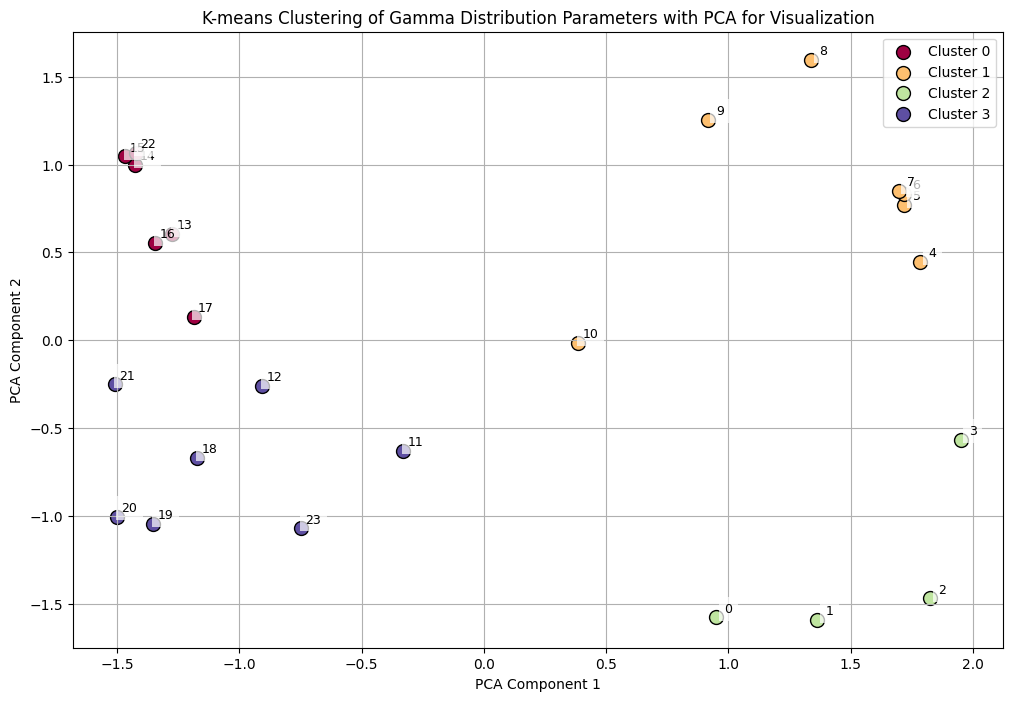


K-Means Clustering (4 Clusters) Table

     Hour      Alpha      Beta  Cluster
0      0   9.296248  3.727144        2
1      1   9.092026  3.365871        2
2      2   8.985907  2.900576        2
3      3   9.727547  2.372165        2
4      4  10.702377  2.049267        1
5      5  11.021481  1.955422        1
6      6  11.078944  1.928818        1
7      7  11.103648  1.938963        1
8      8  11.929598  1.911014        1
9      9  11.821288  2.444952        1
10    10  10.943303  3.499728        1
11    11  10.727875  4.421881        3
12    12  11.323011  4.758560        3
13    13  12.260438  4.685470        0
14    14  12.680151  4.636019        0
15    15  12.741569  4.650658        0
16    16  12.246950  4.770263        0
17    17  11.801808  4.825859        0
18    18  11.084491  5.185255        3
19    19  10.833010  5.519854        3
20    20  10.935822  5.630767        3
21    21  11.609703  5.287972        3
22    22  12.739815  4.602930        0
23    23  10.531145  4.

In [13]:
# Prepare data for K-Means clustering (4 Clusters)
data = params_df_m[['Alpha', 'Beta']].values

# Apply K-means clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=0)
labels = kmeans.fit_predict(data)

# Apply PCA for visualization (on the original data, post-clustering)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

# Add K-Means cluster labels to DataFrame of Parameters
params_df_m['Cluster'] = labels

# Visualize clusters
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(12, 8))
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = data_pca[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], color=col, label=f'Cluster {k}', edgecolor='k', s=100)

    # Annotate each point with the corresponding hour
    hours = params_df_m.loc[class_member_mask, 'Hour'].values
    for i, hour in enumerate(hours):
        # Position the label slightly offset from the point
        plt.text(xy[i, 0] + 0.05, xy[i, 1] + 0.05, str(int(hour)), fontsize=9, ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title('K-means Clustering of Gamma Distribution Parameters with PCA for Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

# Add K-Means cluster labels to DataFrame of Parameters
params_df_m['Cluster'] = labels
print("\nK-Means Clustering (4 Clusters) Table")
print("\n", params_df_m)

# Compute silhouette score
silhouette_avg = silhouette_score(data, labels)
print("\n", f"Silhouette Score K-Mean Cluster (4): {silhouette_avg}")


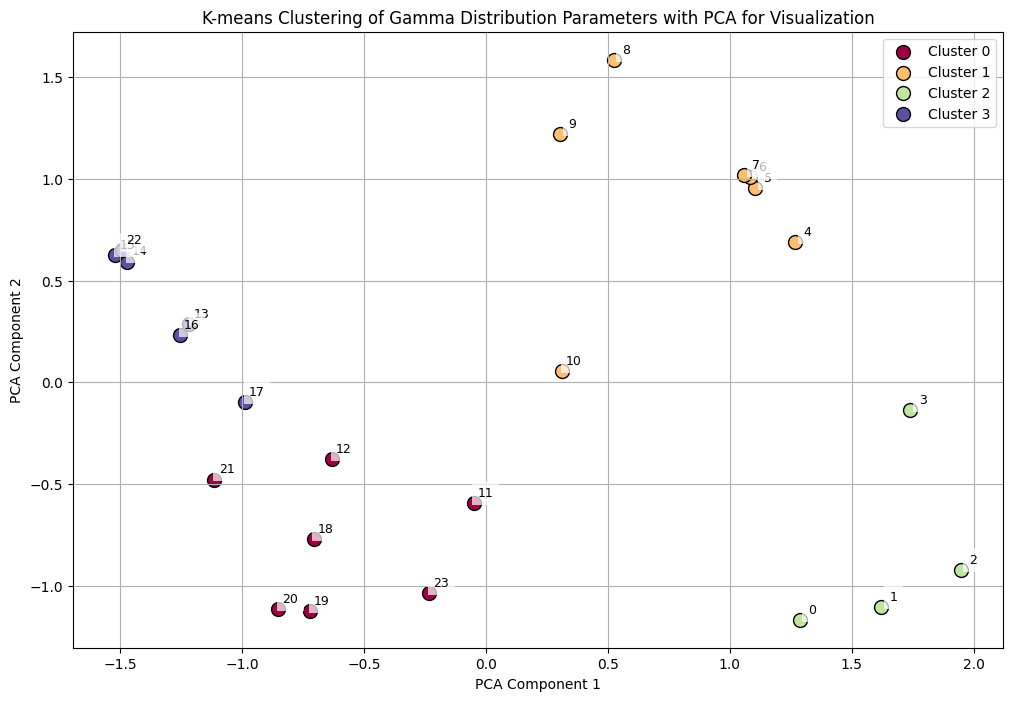


K-Means Clustering (4 Clusters) Table

     Hour      Alpha      Beta  Cluster
0      0   9.296248  3.727144        2
1      1   9.092026  3.365871        2
2      2   8.985907  2.900576        2
3      3   9.727547  2.372165        2
4      4  10.702377  2.049267        1
5      5  11.021481  1.955422        1
6      6  11.078944  1.928818        1
7      7  11.103648  1.938963        1
8      8  11.929598  1.911014        1
9      9  11.821288  2.444952        1
10    10  10.943303  3.499728        1
11    11  10.727875  4.421881        0
12    12  11.323011  4.758560        0
13    13  12.260438  4.685470        3
14    14  12.680151  4.636019        3
15    15  12.741569  4.650658        3
16    16  12.246950  4.770263        3
17    17  11.801808  4.825859        3
18    18  11.084491  5.185255        0
19    19  10.833010  5.519854        0
20    20  10.935822  5.630767        0
21    21  11.609703  5.287972        0
22    22  12.739815  4.602930        3
23    23  10.531145  4.

In [14]:
# Prepare data for K-Means clustering (4 Clusters)
data = params_df_m[['Alpha', 'Beta']].values

# Standardize the data
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data)

# Apply K-means clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=0)
labels = kmeans.fit_predict(data_standardized)

# Apply PCA for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_standardized)

# Add K-Means cluster labels to DataFrame of Parameters
params_df_m['Cluster'] = labels

# Visualize clusters
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(12, 8))
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = data_pca[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], color=col, label=f'Cluster {k}', edgecolor='k', s=100)

    # Annotate each point with the corresponding hour
    hours = params_df_m.loc[class_member_mask, 'Hour'].values
    for i, hour in enumerate(hours):
        # Position the label slightly offset from the point
        plt.text(xy[i, 0] + 0.05, xy[i, 1] + 0.05, str(int(hour)), fontsize=9, ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title('K-means Clustering of Gamma Distribution Parameters with PCA for Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

# Add K-Means cluster labels to DataFrame of Parameters
params_df_m['Cluster'] = labels
print("\nK-Means Clustering (4 Clusters) Table")
print("\n", params_df_m)

# Compute silhouette score
silhouette_avg = silhouette_score(data_standardized, labels)
print("\n", f"Silhouette Score K-Mean Cluster (4): {silhouette_avg}")


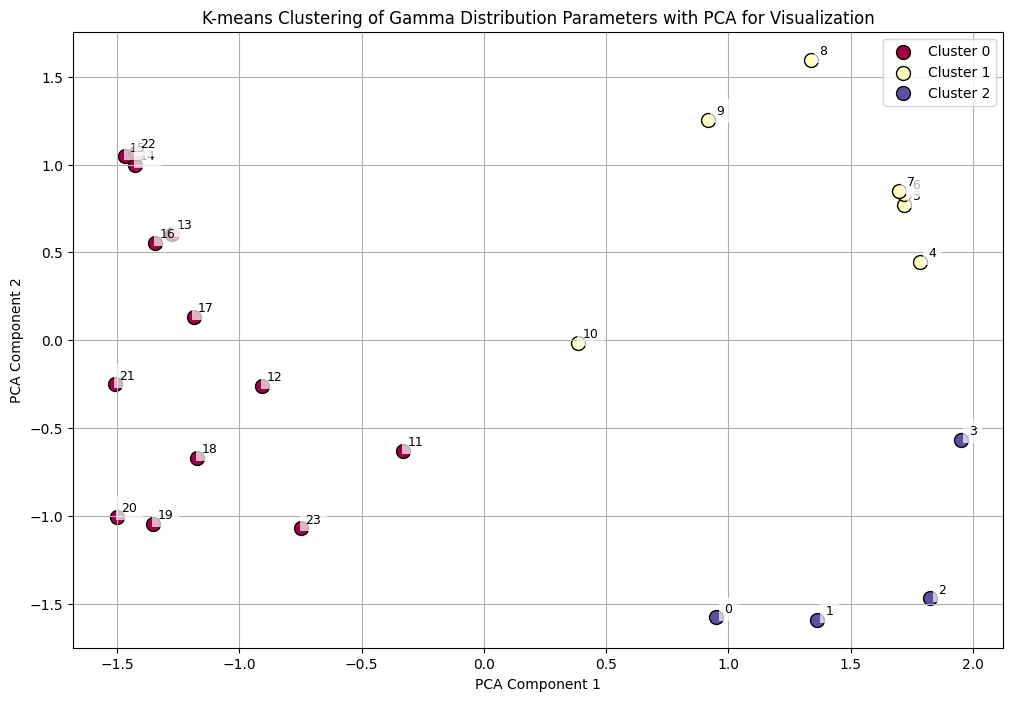


K-Means Clustering (3 Clusters) Table:

     Hour      Alpha      Beta  Cluster
0      0   9.296248  3.727144        2
1      1   9.092026  3.365871        2
2      2   8.985907  2.900576        2
3      3   9.727547  2.372165        2
4      4  10.702377  2.049267        1
5      5  11.021481  1.955422        1
6      6  11.078944  1.928818        1
7      7  11.103648  1.938963        1
8      8  11.929598  1.911014        1
9      9  11.821288  2.444952        1
10    10  10.943303  3.499728        1
11    11  10.727875  4.421881        0
12    12  11.323011  4.758560        0
13    13  12.260438  4.685470        0
14    14  12.680151  4.636019        0
15    15  12.741569  4.650658        0
16    16  12.246950  4.770263        0
17    17  11.801808  4.825859        0
18    18  11.084491  5.185255        0
19    19  10.833010  5.519854        0
20    20  10.935822  5.630767        0
21    21  11.609703  5.287972        0
22    22  12.739815  4.602930        0
23    23  10.531145  4

In [15]:
# @title **K-means clustering (3 Clusters)**

# Prepare data for K-Means clustering (4 Clusters)
data = params_df_m[['Alpha', 'Beta']].values

# Standardize the features
#scaler = StandardScaler()
data_standardized = data.copy()
# Apply K-means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=0)
labels = kmeans.fit_predict(data_standardized)

# Apply PCA for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_standardized)

# Add K-Means cluster labels to DataFrame of Parameters
params_df_m['Cluster'] = labels

# Visualize clusters
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(12, 8))
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = data_pca[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], color=col, label=f'Cluster {k}', edgecolor='k', s=100)

    # Annotate each point with the corresponding hour
    hours = params_df_m.loc[class_member_mask, 'Hour'].values
    for i, hour in enumerate(hours):
        # Position the label slightly offset from the point
        plt.text(xy[i, 0] + 0.05, xy[i, 1] + 0.05, str(int(hour)), fontsize=9, ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title('K-means Clustering of Gamma Distribution Parameters with PCA for Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

# Add K-Means cluster labels to DataFrame of Parameters
params_df_m['Cluster'] = labels
print("\nK-Means Clustering (3 Clusters) Table:")
print("\n", params_df_m)

# Compute silhouette score
silhouette_avg = silhouette_score(data_standardized, labels)
print("\n", f"Silhouette Score K-Mean Cluster (3): {silhouette_avg}")


# ***DBSCAN Method***

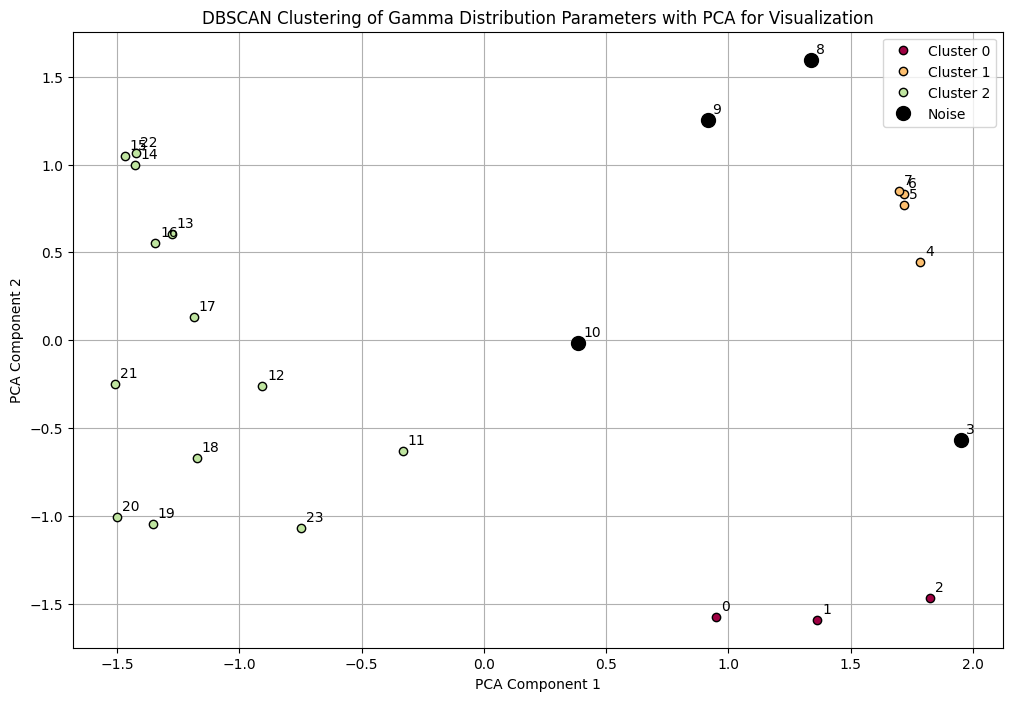


DBSCAN Clustering (4 Clusters) Table:

     Hour      Alpha      Beta  Cluster
0      0   9.296248  3.727144        0
1      1   9.092026  3.365871        0
2      2   8.985907  2.900576        0
3      3   9.727547  2.372165       -1
4      4  10.702377  2.049267        1
5      5  11.021481  1.955422        1
6      6  11.078944  1.928818        1
7      7  11.103648  1.938963        1
8      8  11.929598  1.911014       -1
9      9  11.821288  2.444952       -1
10    10  10.943303  3.499728       -1
11    11  10.727875  4.421881        2
12    12  11.323011  4.758560        2
13    13  12.260438  4.685470        2
14    14  12.680151  4.636019        2
15    15  12.741569  4.650658        2
16    16  12.246950  4.770263        2
17    17  11.801808  4.825859        2
18    18  11.084491  5.185255        2
19    19  10.833010  5.519854        2
20    20  10.935822  5.630767        2
21    21  11.609703  5.287972        2
22    22  12.739815  4.602930        2
23    23  10.531145  4.

In [16]:
# @title **DBSCAN clustering (4 Clusters)**

# Prepare data for clustering
data = params_df_m[['Alpha', 'Beta']].values

# Standardize the features
#scaler = StandardScaler()
data_standardized = data.copy()

# Apply DBSCAN for clustering
# Configure DBSCAN parameters
epsilon = 0.7
min_samples = 3

# Apply DBSCAN
db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(data_standardized)
labels_db = db.labels_

# Apply PCA for visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_standardized)

# Visualize clusters
unique_labels = set(labels_db)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(12, 8))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black color for noise
        col = [0, 0, 0, 1]

    class_member_mask = (labels_db == k)

    xy = data_pca[class_member_mask]
    hours = params_df_m['Hour'].values[class_member_mask]

    # Plot points with smaller markers
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10 if k == -1 else 6,
             label='Noise' if k == -1 else f'Cluster {k}')

    # Annotate with hours slightly away from the points
    for i, hour in enumerate(hours):
        plt.text(xy[i, 0] + 0.02, xy[i, 1] + 0.02, str(hour), fontsize=10, ha='left', va='bottom')

plt.title('DBSCAN Clustering of Gamma Distribution Parameters with PCA for Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.legend()
plt.show()

# Add DBSCAN cluster labels to DataFrame of Parameters
params_df_m['Cluster'] = labels_db
print("\nDBSCAN Clustering (4 Clusters) Table:")
print("\n", params_df_m)

# Compute silhouette score
silhouette_avg = silhouette_score(data_standardized, labels)
print("\n", f"Silhouette Score DBSCAN Cluster (4): {silhouette_avg}")


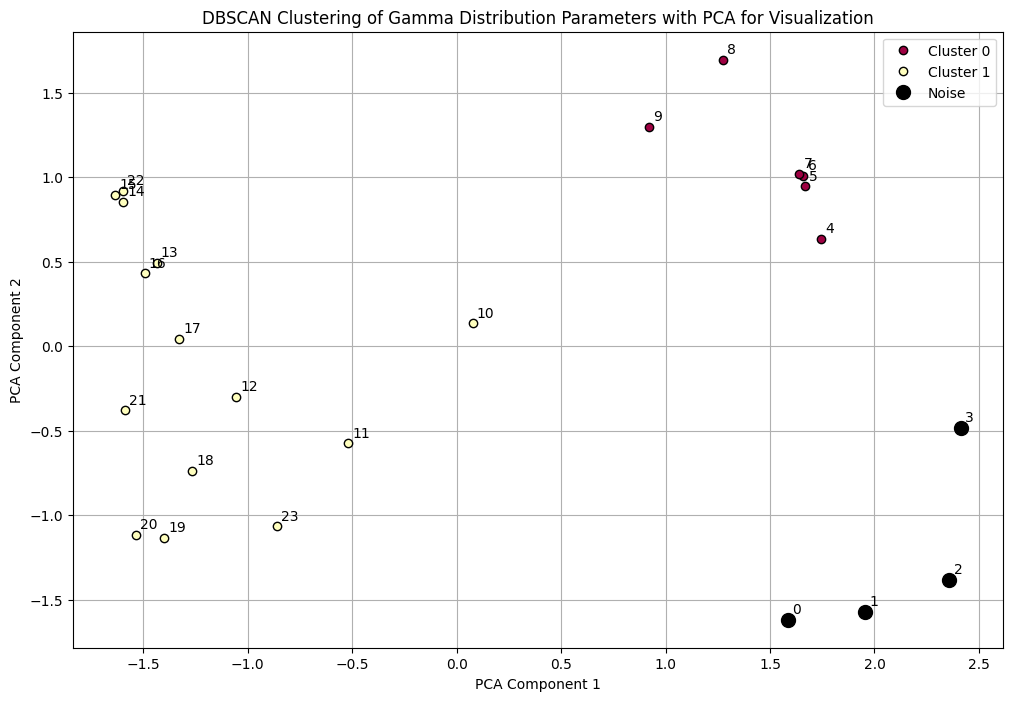

    Hour      Alpha      Beta  Cluster
0      0   9.296248  3.727144       -1
1      1   9.092026  3.365871       -1
2      2   8.985907  2.900576       -1
3      3   9.727547  2.372165       -1
4      4  10.702377  2.049267        0
5      5  11.021481  1.955422        0
6      6  11.078944  1.928818        0
7      7  11.103648  1.938963        0
8      8  11.929598  1.911014        0
9      9  11.821288  2.444952        0
10    10  10.943303  3.499728        1
11    11  10.727875  4.421881        1
12    12  11.323011  4.758560        1
13    13  12.260438  4.685470        1
14    14  12.680151  4.636019        1
15    15  12.741569  4.650658        1
16    16  12.246950  4.770263        1
17    17  11.801808  4.825859        1
18    18  11.084491  5.185255        1
19    19  10.833010  5.519854        1
20    20  10.935822  5.630767        1
21    21  11.609703  5.287972        1
22    22  12.739815  4.602930        1
23    23  10.531145  4.993678        1
Silhouette Score DBSCAN C

In [17]:
# @title **DBSCAN

# Prepare data for clustering (assumed params_df_m is already available)
data = params_df_m[['Alpha', 'Beta']].values

# Apply DBSCAN for clustering
epsilon = 0.95
min_samples = 5
db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(data)
labels_db = db.labels_

# Add DBSCAN cluster labels to DataFrame of Parameters
params_df_m['Cluster'] = labels_db

# Create new data set for PCA: Optionally combine original data with cluster labels
data_with_clusters = np.hstack((data, labels_db.reshape(-1, 1)))

# Apply PCA on the new data (original data combined with cluster labels)
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_with_clusters)

# Visualize clusters after PCA
unique_labels = set(labels_db)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(12, 8))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black color for noise
        col = [0, 0, 0, 1]

    class_member_mask = (labels_db == k)

    xy = data_pca[class_member_mask]
    hours = params_df_m['Hour'].values[class_member_mask]

    # Plot points with smaller markers
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=10 if k == -1 else 6,
             label='Noise' if k == -1 else f'Cluster {k}')

    # Annotate with hours slightly away from the points
    for i, hour in enumerate(hours):
        plt.text(xy[i, 0] + 0.02, xy[i, 1] + 0.02, str(hour), fontsize=10, ha='left', va='bottom')

plt.title('DBSCAN Clustering of Gamma Distribution Parameters with PCA for Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.legend()
plt.show()

print(params_df_m)
#  compute silhouette score or other metrics
silhouette_avg = silhouette_score(data_standardized, labels)
print(f"Silhouette Score DBSCAN Cluster: {silhouette_avg}")

print("\nDBSCAN Clustering (4 Clusters) Table:")



# ***Additional Clustering ***

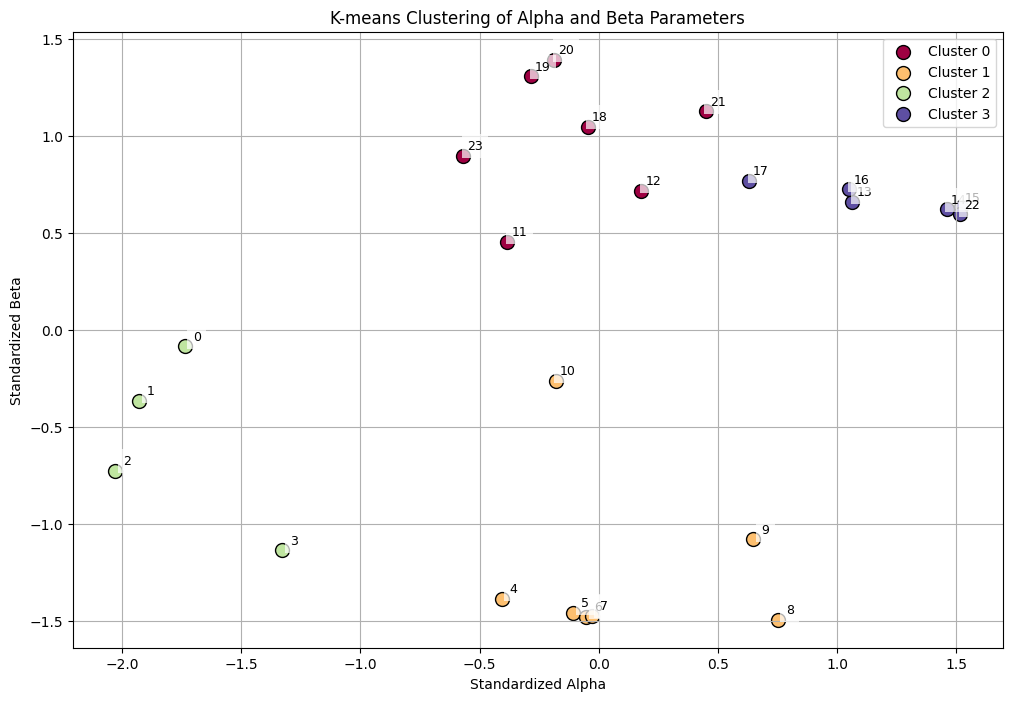


K-Means Clustering (2 Clusters) Table

     Hour      Alpha      Beta  Cluster
0      0   9.296248  3.727144        2
1      1   9.092026  3.365871        2
2      2   8.985907  2.900576        2
3      3   9.727547  2.372165        2
4      4  10.702377  2.049267        1
5      5  11.021481  1.955422        1
6      6  11.078944  1.928818        1
7      7  11.103648  1.938963        1
8      8  11.929598  1.911014        1
9      9  11.821288  2.444952        1
10    10  10.943303  3.499728        1
11    11  10.727875  4.421881        0
12    12  11.323011  4.758560        0
13    13  12.260438  4.685470        3
14    14  12.680151  4.636019        3
15    15  12.741569  4.650658        3
16    16  12.246950  4.770263        3
17    17  11.801808  4.825859        3
18    18  11.084491  5.185255        0
19    19  10.833010  5.519854        0
20    20  10.935822  5.630767        0
21    21  11.609703  5.287972        0
22    22  12.739815  4.602930        3
23    23  10.531145  4.

In [18]:
# @title **Preparing data for K-means clustering (4 Clusters)**

# Prepare data for K-Means clustering (2 Clusters)
data = params_df_m[['Alpha', 'Beta']].values

# Standardize the features
scaler = StandardScaler()
data_standardized = scaler.fit_transform(data)

# Apply K-means clustering
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=0)
labels = kmeans.fit_predict(data_standardized)

# Add K-Means cluster labels to DataFrame of Parameters
params_df_m['Cluster'] = labels

# Visualize clusters
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(12, 8))
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = data_standardized[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], color=col, label=f'Cluster {k}', edgecolor='k', s=100)

    # Annotate each point with the corresponding hour
    hours = params_df_m.loc[class_member_mask, 'Hour'].values
    for i, hour in enumerate(hours):
        # Position the label slightly offset from the point
        plt.text(xy[i, 0] + 0.05, xy[i, 1] + 0.05, str(int(hour)), fontsize=9, ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title('K-means Clustering of Alpha and Beta Parameters')
plt.xlabel('Standardized Alpha')
plt.ylabel('Standardized Beta')
plt.legend()
plt.grid(True)
plt.show()

# Print the DataFrame with cluster labels
print("\nK-Means Clustering (2 Clusters) Table")
print("\n", params_df_m)

# Compute silhouette score
silhouette_avg = silhouette_score(data_standardized, labels)
print("\n", f"Silhouette Score K-Mean Cluster (2): {silhouette_avg}")


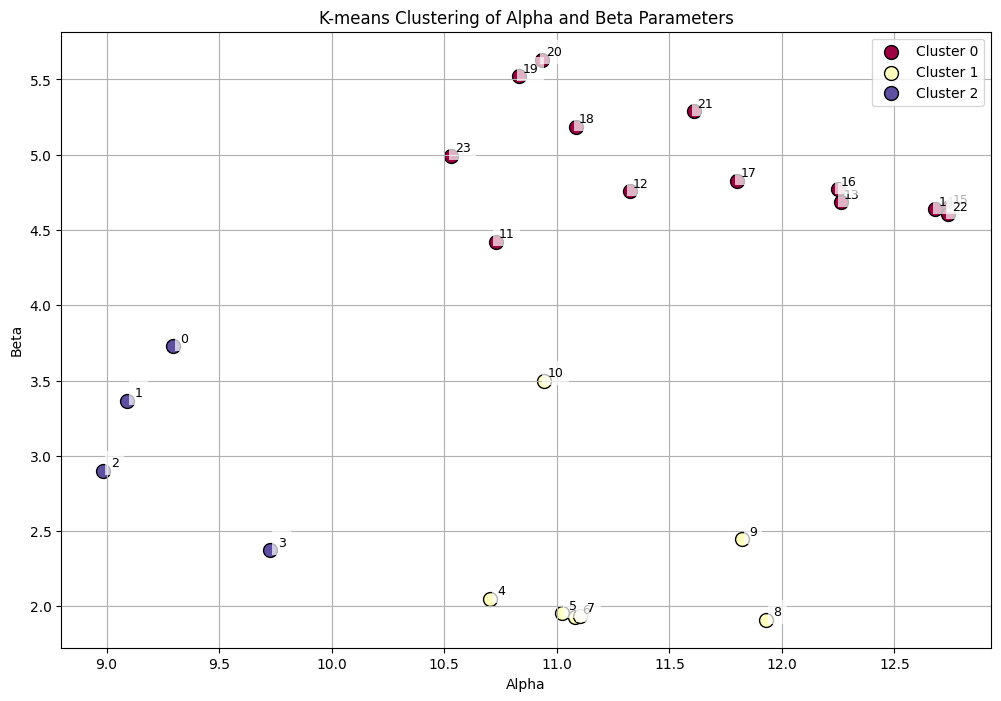


K-Means Clustering (3 Clusters) Table

     Hour      Alpha      Beta  Cluster
0      0   9.296248  3.727144        2
1      1   9.092026  3.365871        2
2      2   8.985907  2.900576        2
3      3   9.727547  2.372165        2
4      4  10.702377  2.049267        1
5      5  11.021481  1.955422        1
6      6  11.078944  1.928818        1
7      7  11.103648  1.938963        1
8      8  11.929598  1.911014        1
9      9  11.821288  2.444952        1
10    10  10.943303  3.499728        1
11    11  10.727875  4.421881        0
12    12  11.323011  4.758560        0
13    13  12.260438  4.685470        0
14    14  12.680151  4.636019        0
15    15  12.741569  4.650658        0
16    16  12.246950  4.770263        0
17    17  11.801808  4.825859        0
18    18  11.084491  5.185255        0
19    19  10.833010  5.519854        0
20    20  10.935822  5.630767        0
21    21  11.609703  5.287972        0
22    22  12.739815  4.602930        0
23    23  10.531145  4.

In [19]:
# @title **Preparing data for K-means clustering (3 cllusters)**

# Prepare data for K-Means clustering ( Clusters)
data = params_df_m[['Alpha', 'Beta']].values

# Standardize the features
#scaler = StandardScaler()
data_standardized = data.copy()

# Apply K-means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=0)
labels = kmeans.fit_predict(data_standardized)

# Add K-Means cluster labels to DataFrame of Parameters
params_df_m['Cluster'] = labels

# Visualize clusters
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(12, 8))
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = data_standardized[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], color=col, label=f'Cluster {k}', edgecolor='k', s=100)

    # Annotate each point with the corresponding hour
    hours = params_df_m.loc[class_member_mask, 'Hour'].values
    for i, hour in enumerate(hours):
        # Position the label slightly offset from the point
        plt.text(xy[i, 0] + 0.05, xy[i, 1] + 0.05, str(int(hour)), fontsize=9, ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title('K-means Clustering of Alpha and Beta Parameters')
plt.xlabel('Alpha')
plt.ylabel('Beta')
plt.legend()
plt.grid(True)
plt.show()

# Print the DataFrame with cluster labels
print("\nK-Means Clustering (3 Clusters) Table")
print("\n", params_df_m)

# Compute silhouette score
silhouette_avg = silhouette_score(data_standardized, labels)
print("\n", f"Silhouette Score K-Mean Cluster (2): {silhouette_avg}")


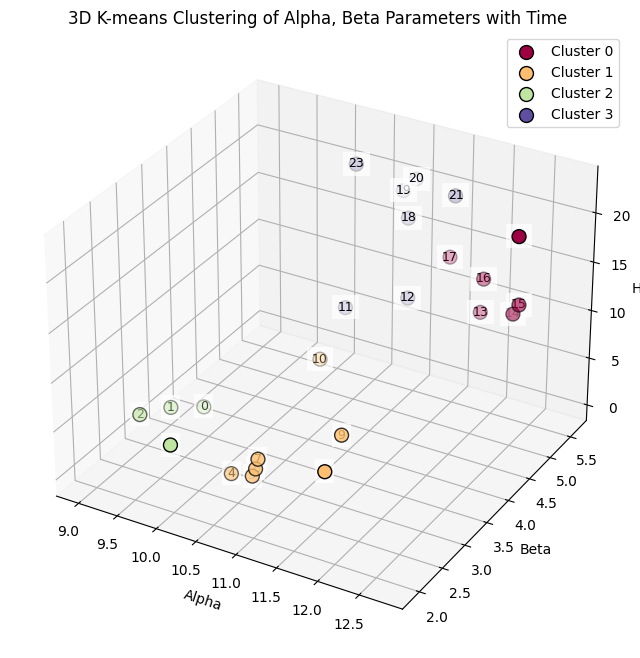


K-Means Clustering (4 Clusters) Table
    Hour      Alpha      Beta  Cluster
0      0   9.296248  3.727144        2
1      1   9.092026  3.365871        2
2      2   8.985907  2.900576        2
3      3   9.727547  2.372165        2
4      4  10.702377  2.049267        1
5      5  11.021481  1.955422        1
6      6  11.078944  1.928818        1
7      7  11.103648  1.938963        1
8      8  11.929598  1.911014        1
9      9  11.821288  2.444952        1
10    10  10.943303  3.499728        1
11    11  10.727875  4.421881        3
12    12  11.323011  4.758560        3
13    13  12.260438  4.685470        0
14    14  12.680151  4.636019        0
15    15  12.741569  4.650658        0
16    16  12.246950  4.770263        0
17    17  11.801808  4.825859        0
18    18  11.084491  5.185255        3
19    19  10.833010  5.519854        3
20    20  10.935822  5.630767        3
21    21  11.609703  5.287972        3
22    22  12.739815  4.602930        0
23    23  10.531145  4.99

In [23]:
# Prepare data for K-Means clustering (4 Clusters)
data = params_df_m[['Alpha', 'Beta']].values

# Apply K-means clustering without standardizing
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=0)
labels = kmeans.fit_predict(data)

# Add K-Means cluster labels to DataFrame of Parameters
params_df_m['Cluster'] = labels

# Visualize clusters in 3D
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xyz = data[class_member_mask]
    time_k = params_df_m.loc[class_member_mask, 'Hour'].values

    ax.scatter(xyz[:, 0], xyz[:, 1], time_k, color=col, label=f'Cluster {k}', edgecolor='k', s=100)

    # Annotate each point with the corresponding hour
    for i, hour in enumerate(time_k):
        ax.text(xyz[i, 0], xyz[i, 1], time_k[i] + 0.05, str(int(hour)), fontsize=9, ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

ax.set_title('3D K-means Clustering of Alpha, Beta Parameters with Time')
ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.set_zlabel('Hour')
ax.legend()
plt.show()

# Print the DataFrame with cluster labels
print("\nK-Means Clustering (4 Clusters) Table")
print(params_df_m)

# Compute silhouette score
silhouette_avg = silhouette_score(data_standardized, labels)
print("\n", f"Silhouette Score K-Mean Cluster (2): {silhouette_avg}")


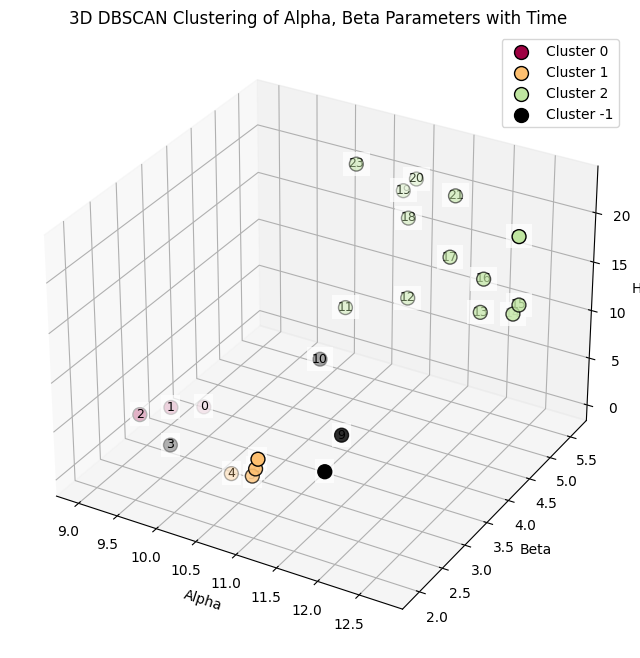


DBSCAN Clustering Table
    Hour      Alpha      Beta  Cluster
0      0   9.296248  3.727144        0
1      1   9.092026  3.365871        0
2      2   8.985907  2.900576        0
3      3   9.727547  2.372165       -1
4      4  10.702377  2.049267        1
5      5  11.021481  1.955422        1
6      6  11.078944  1.928818        1
7      7  11.103648  1.938963        1
8      8  11.929598  1.911014       -1
9      9  11.821288  2.444952       -1
10    10  10.943303  3.499728       -1
11    11  10.727875  4.421881        2
12    12  11.323011  4.758560        2
13    13  12.260438  4.685470        2
14    14  12.680151  4.636019        2
15    15  12.741569  4.650658        2
16    16  12.246950  4.770263        2
17    17  11.801808  4.825859        2
18    18  11.084491  5.185255        2
19    19  10.833010  5.519854        2
20    20  10.935822  5.630767        2
21    21  11.609703  5.287972        2
22    22  12.739815  4.602930        2
23    23  10.531145  4.993678        2


In [24]:

# Prepare data for DBSCAN clustering
data = params_df_m[['Alpha', 'Beta']].values

# Apply DBSCAN clustering
eps_value = 0.7
min_samples_value = 3

dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
labels = dbscan.fit_predict(data)

# Add DBSCAN cluster labels to DataFrame of Parameters
params_df_m['Cluster'] = labels

# Visualize clusters in 3D
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xyz = data[class_member_mask]
    time_k = params_df_m.loc[class_member_mask, 'Hour'].values

    ax.scatter(xyz[:, 0], xyz[:, 1], time_k, color=col, label=f'Cluster {k}', edgecolor='k', s=100)

    # Annotate each point with the corresponding hour
    for i, hour in enumerate(time_k):
        ax.text(xyz[i, 0], xyz[i, 1], time_k[i] + 0.05, str(int(hour)), fontsize=9, ha='center', va='center', color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

ax.set_title('3D DBSCAN Clustering of Alpha, Beta Parameters with Time')
ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.set_zlabel('Hour')
ax.legend()
plt.show()

# Print the DataFrame with cluster labels
print("\nDBSCAN Clustering Table")
print(params_df_m)

# Compute silhouette score
silhouette_avg = silhouette_score(data, labels)
print("\n", f"Silhouette Score K-Mean Cluster (2): {silhouette_avg}")

# ***Eveluation Silhouette Score***

In [22]:
# @title Manually input Armony label
# Path to the CSV file containing the patient visit table
csv_path_a1 = os.path.join(directory, 'Armony et al. 2015 - Sheet3.csv')

# Read the CSV file into a DataFrame
df_arm = pd.read_csv(csv_path_a1)

df_Arm = df_arm
print(df_Arm)


# Extract features for clustering
features = df_Arm[['Alpha', 'Beta']].values

# Extract cluster labels
labels = df_Arm['Cluster'].values

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(features, labels)
print(f"Silhouette Score: {silhouette_avg}")


    Hour      Alpha      Beta  Cluster                   Insight by eye
0      0   9.296248  3.727144        0  intermediate hours (0:00-2:00).
1      1   9.092026  3.365871        0  intermediate hours (0:00-2:00).
2      2   8.985907  2.900576        0  intermediate hours (0:00-2:00).
3      3   9.727547  2.372165        1        early morning (3:00-8:59)
4      4  10.702377  2.049267        1        early morning (3:00-8:59)
5      5  11.021481  1.955422        1        early morning (3:00-8:59)
6      6  11.078944  1.928818        1        early morning (3:00-8:59)
7      7  11.103648  1.938963        1        early morning (3:00-8:59)
8      8  11.929599  1.911014        1        early morning (3:00-8:59)
9      9  11.821288  2.444952        1        early morning (3:00-8:59)
10    10  10.943303  3.499728        0   intermediate hours (9:00-11:59
11    11  10.727875  4.421881        0   intermediate hours (9:00-11:59
12    12  11.323011  4.758560        2           PM hours (12:00

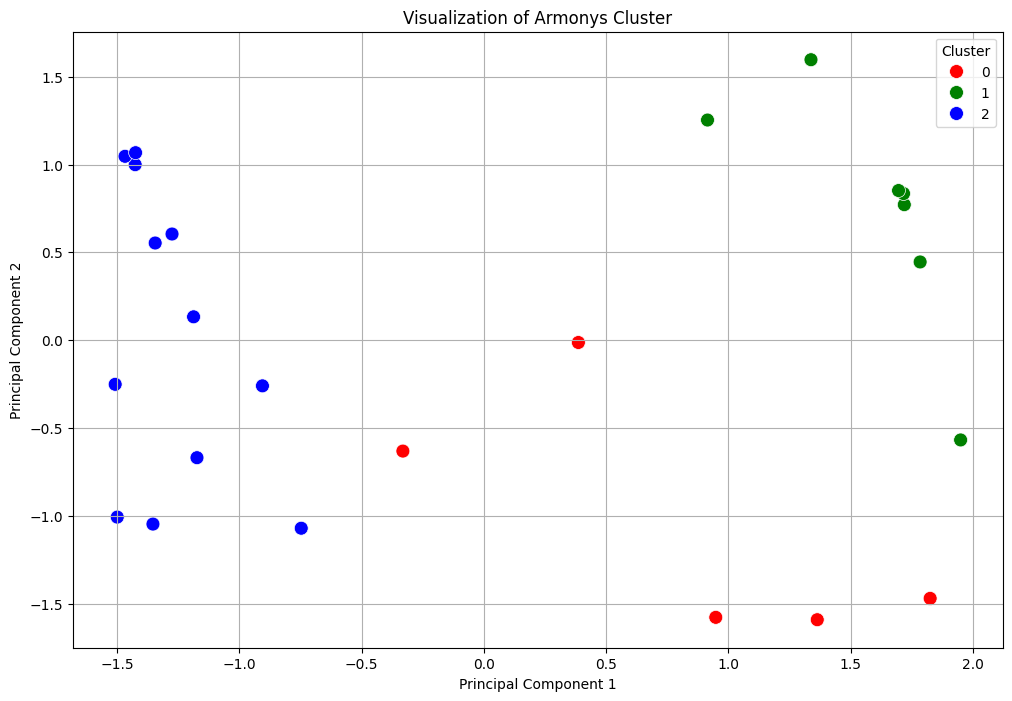

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Assuming df_Arm is already defined and contains 'Alpha', 'Beta', and 'Cluster' columns

# Prepare data for PCA
features = df_Arm[['Alpha', 'Beta']]
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df_Arm['Cluster']

# Define a color palette with specified colors
palette = {0: 'red', 1: 'green', 2: 'blue'}

# Scatter plot of PCA results
plt.figure(figsize=(12, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette=palette, s=100, edgecolor='w', linewidth=0.5)
plt.title('Visualization of Armonys Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


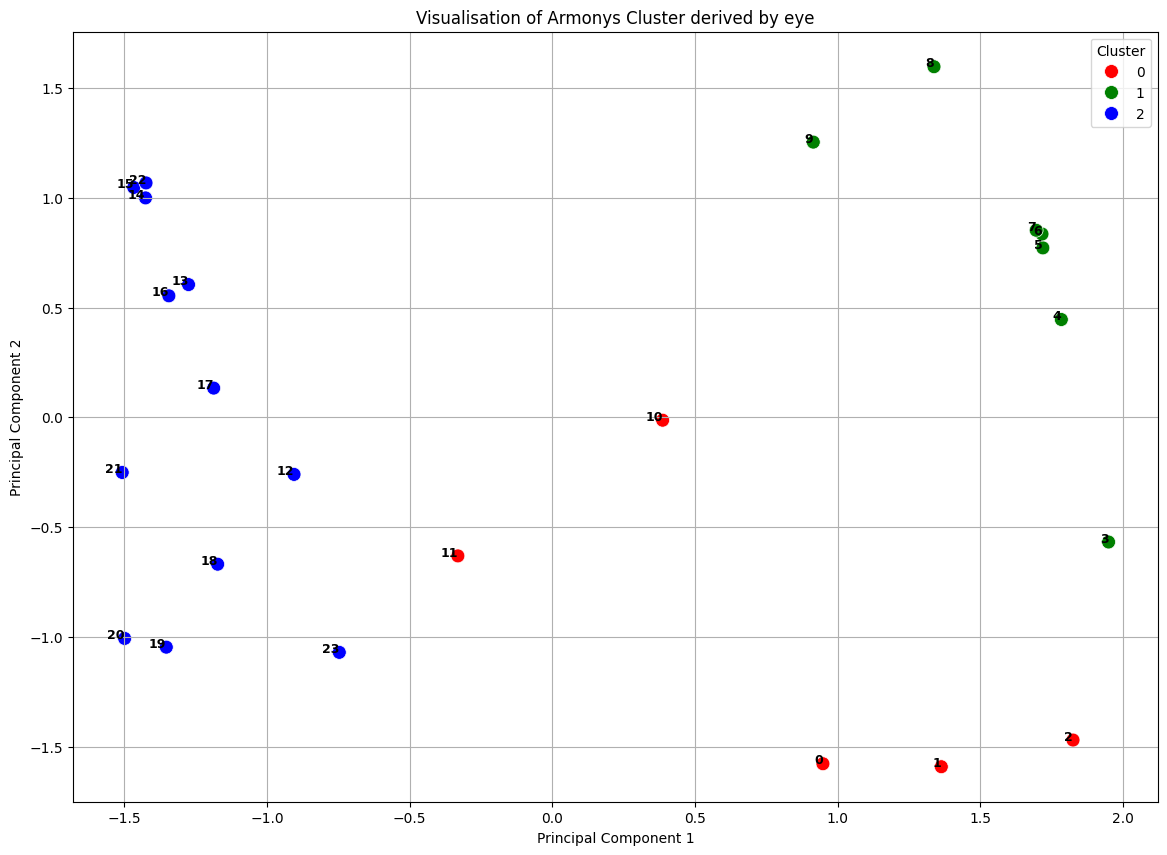

Silhouette Score: 0.490


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Prepare data for PCA
features = df_Arm[['Alpha', 'Beta']]
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features)

# Create a DataFrame with PCA results and hours
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df_Arm['Cluster']
pca_df['Hour'] = df_Arm['Hour']

# Define a color palette with specified colors
palette = {0: 'red', 1: 'green', 2: 'blue'}

# Scatter plot of PCA results with annotations
plt.figure(figsize=(14, 10))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette=palette, s=100, edgecolor='w', linewidth=0.5)

# Annotate each point with its corresponding hour
for i in range(pca_df.shape[0]):
    plt.text(pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i], str(pca_df['Hour'].iloc[i]),
             fontsize=9, ha='right', color='black', weight='bold')

plt.title('Visualisation of Armonys Cluster derived by eye')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Prepare data for PCA
features = df_Arm[['Alpha', 'Beta']]

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(features, df_Arm['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.3f}')


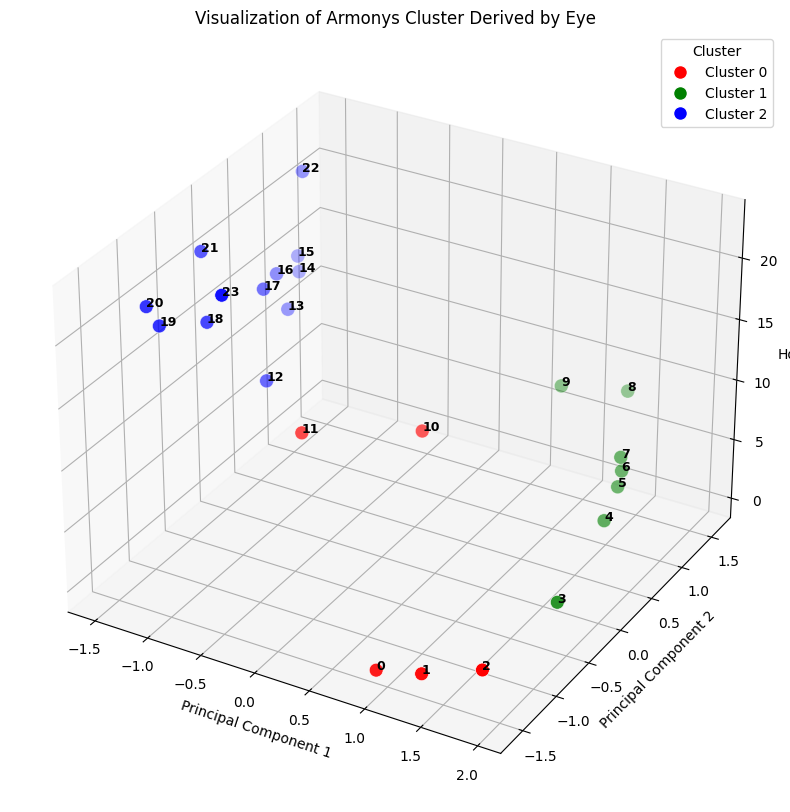

Silhouette Score: 0.490


In [41]:


# Prepare data for PCA
features = df_Arm[['Alpha', 'Beta']]
pca = PCA(n_components=2)  # Reduce to 2 components
principal_components = pca.fit_transform(features)

# Create a DataFrame with PCA results and hours
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df_Arm['Cluster']
pca_df['Hour'] = df_Arm['Hour']

# Define a color palette with specified colors
palette = {0: 'red', 1: 'green', 2: 'blue'}

# 3D Scatter plot of PCA results with Hour as the third dimension
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using PC1 and PC2, with Hour as the z-axis
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['Hour'],
                     c=pca_df['Cluster'].map(palette), s=100, edgecolor='w', linewidth=0.5)

# Annotate each point with its corresponding hour
for i in range(pca_df.shape[0]):
    ax.text(pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i], pca_df['Hour'].iloc[i],
            str(pca_df['Hour'].iloc[i]), fontsize=9, color='black', weight='bold')

# Labels and title
ax.set_title('Visualization of Armonys Cluster Derived by Eye')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Hour')

# Create legend manually
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10, label=f'Cluster {i}') for i in palette]
ax.legend(handles=handles, title='Cluster')

plt.show()

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(features, df_Arm['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.3f}')


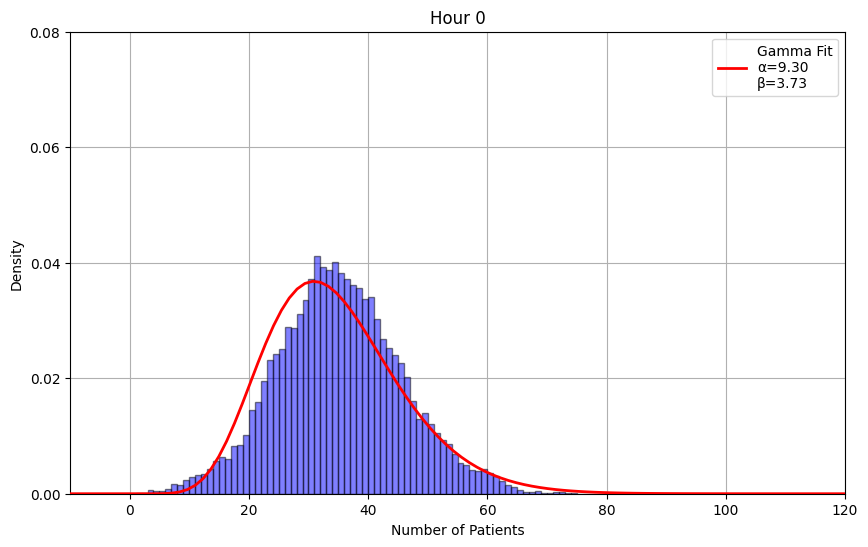

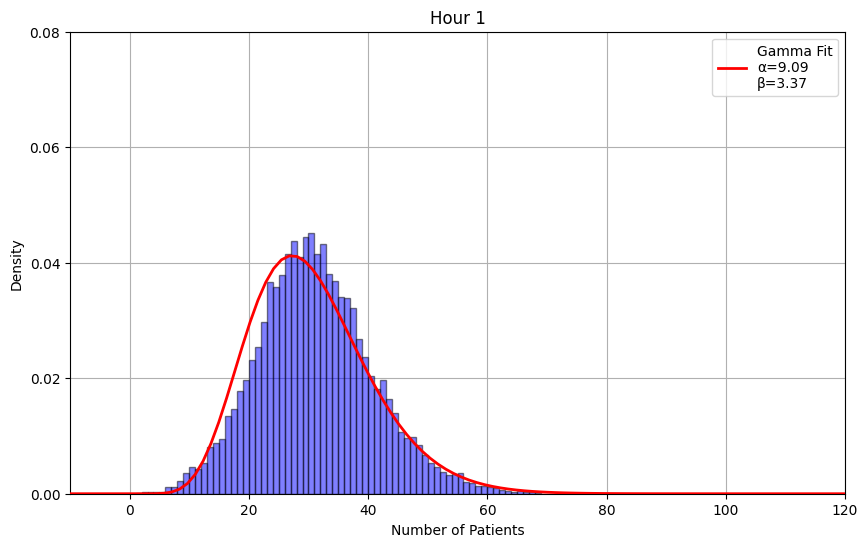

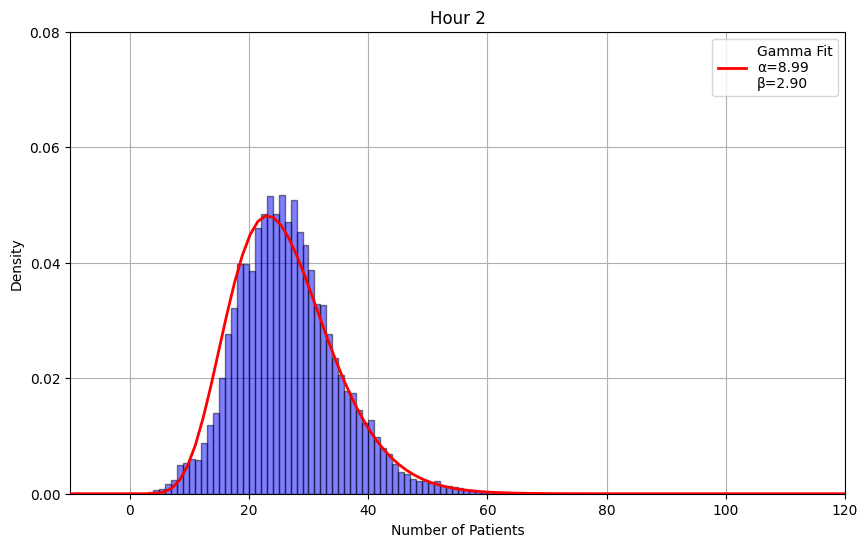

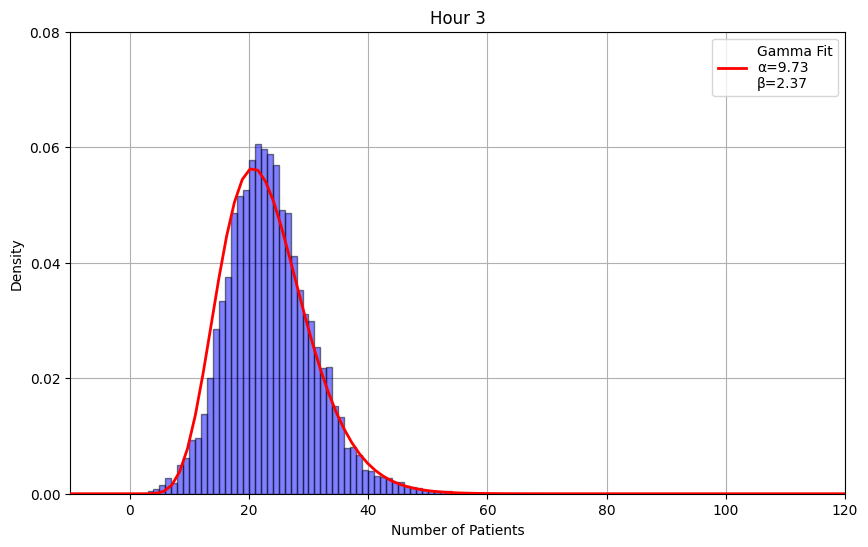

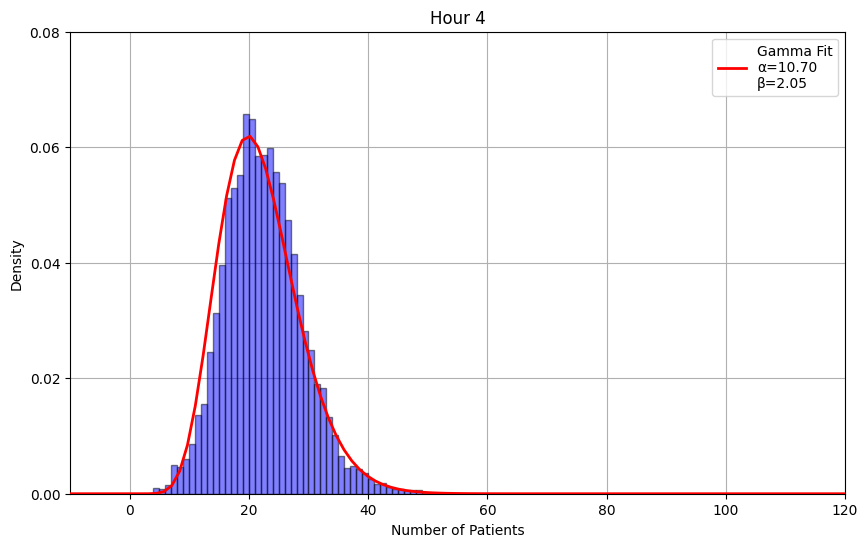

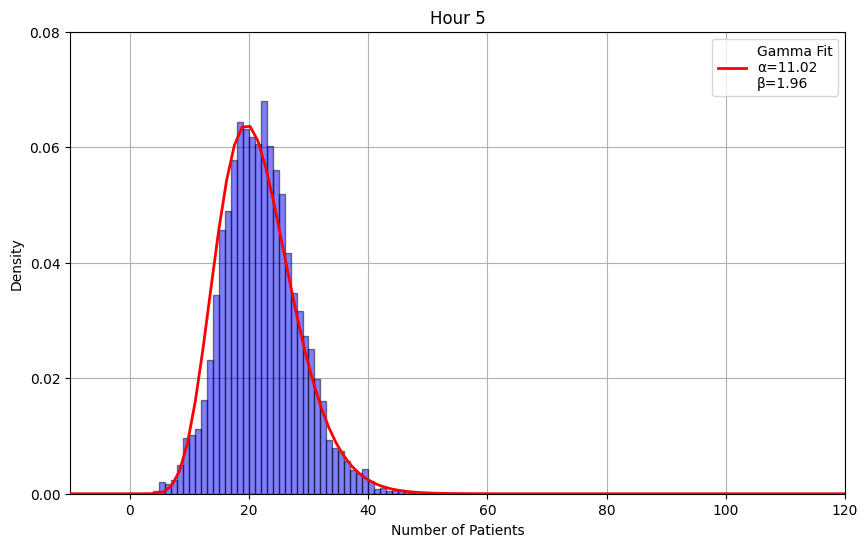

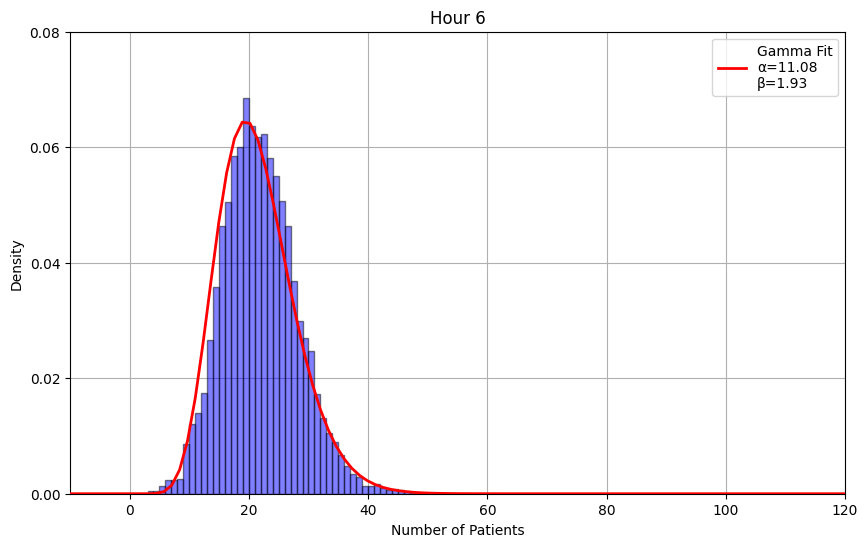

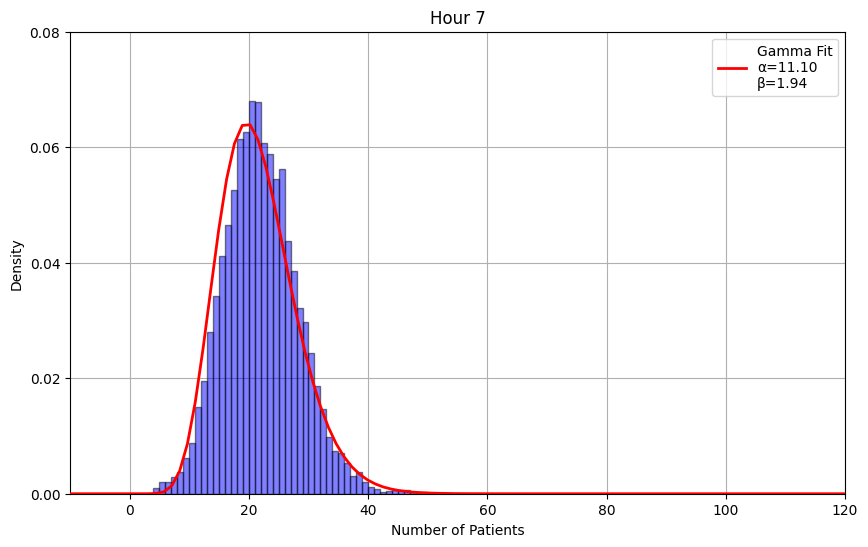

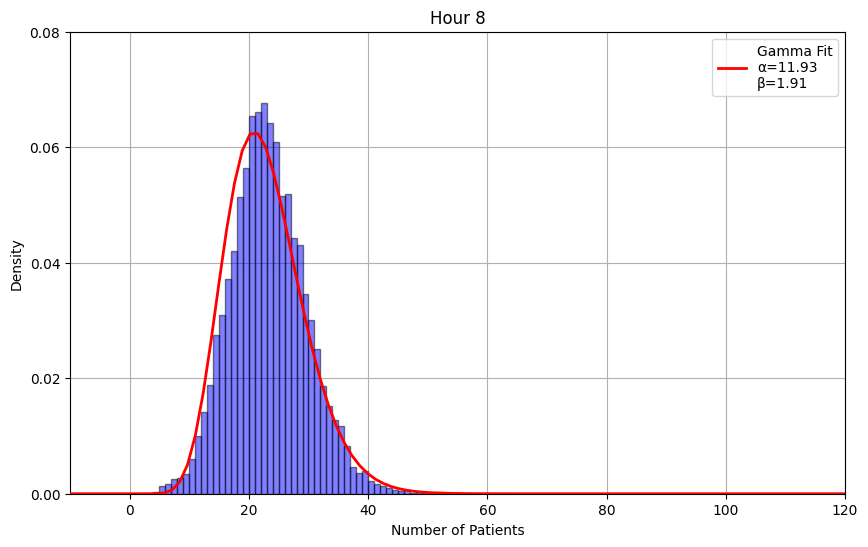

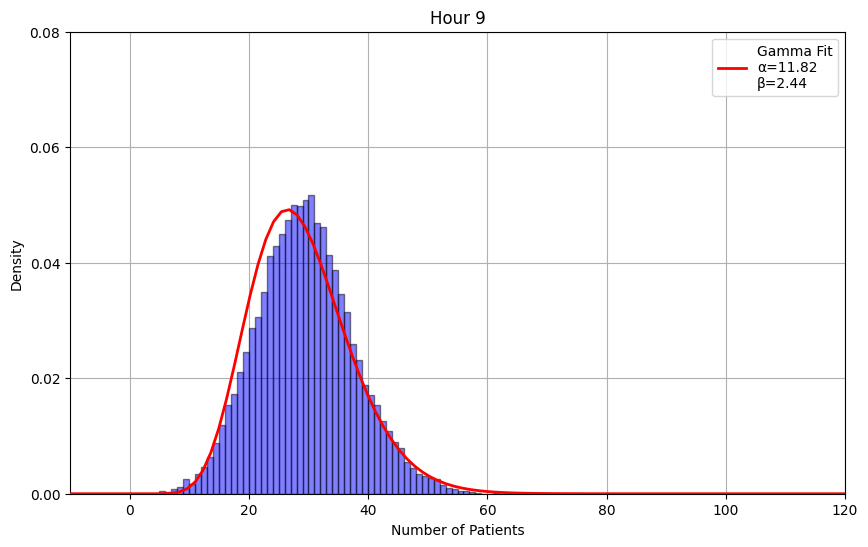

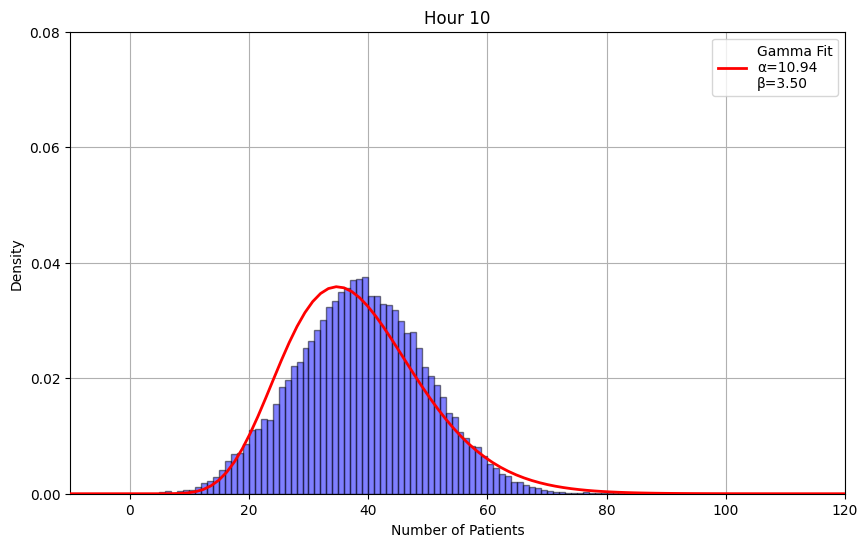

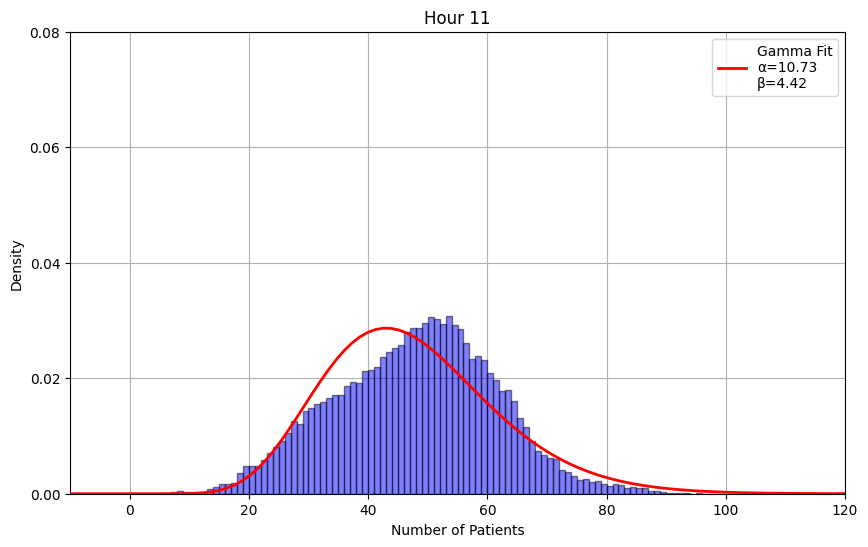

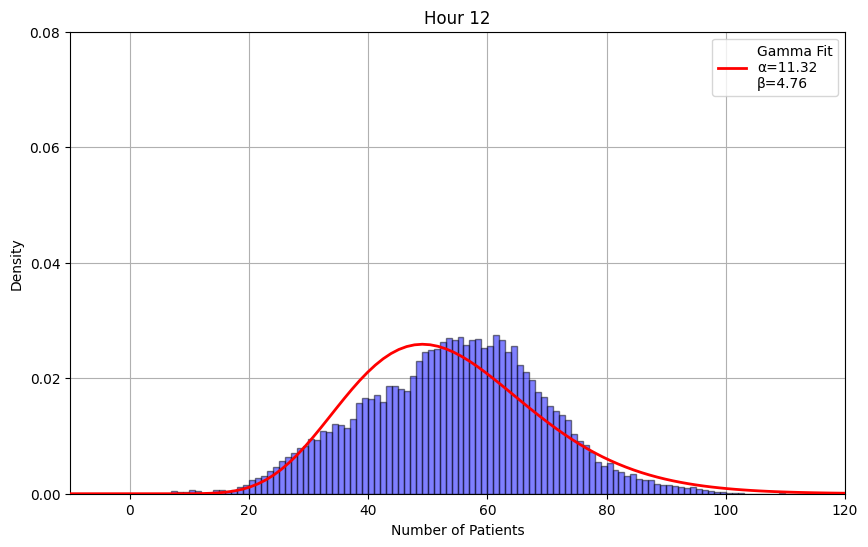

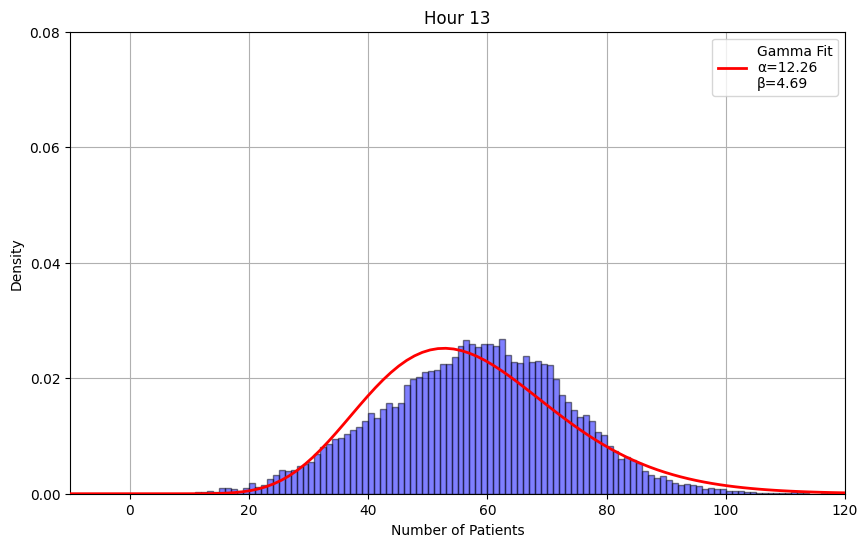

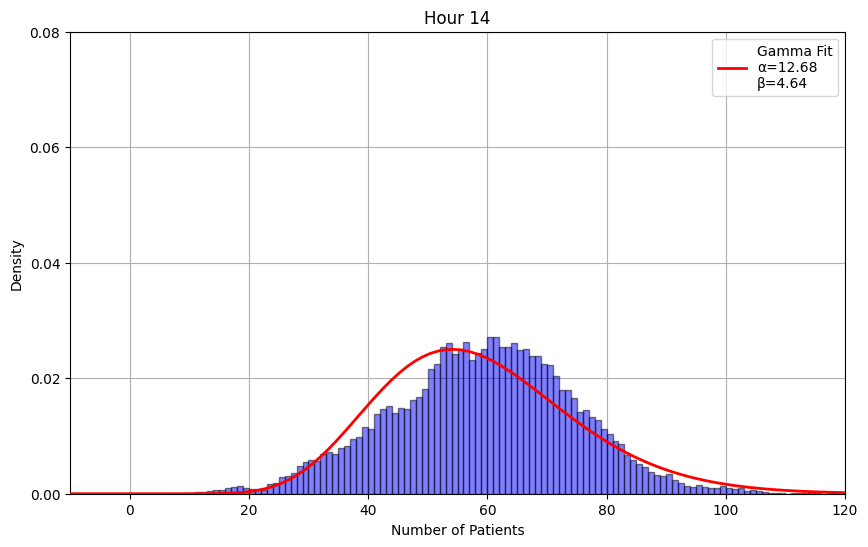

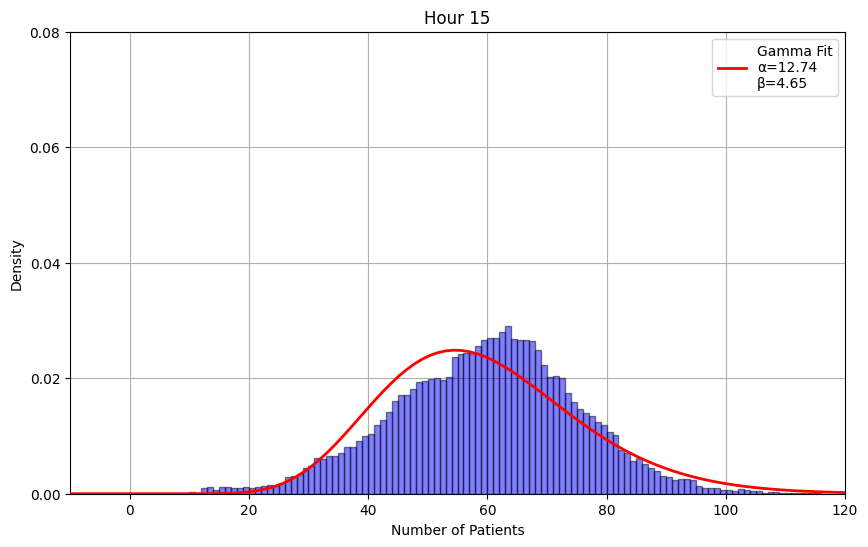

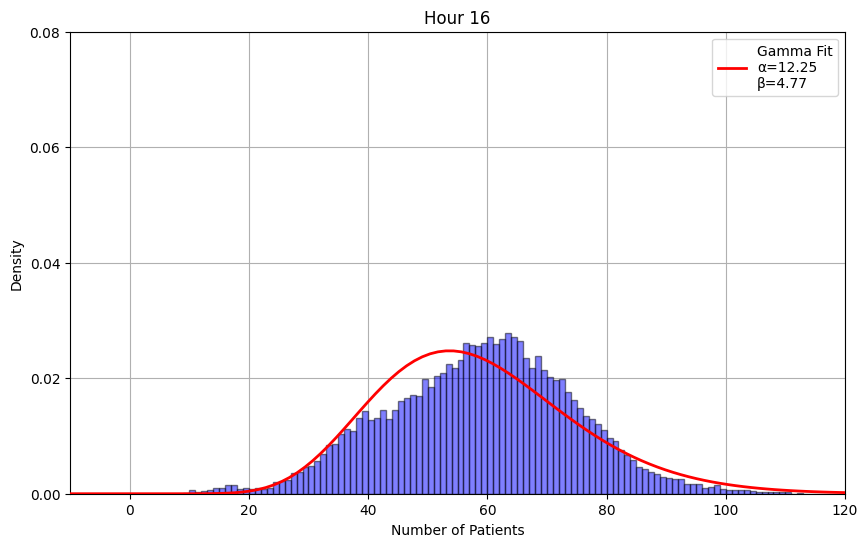

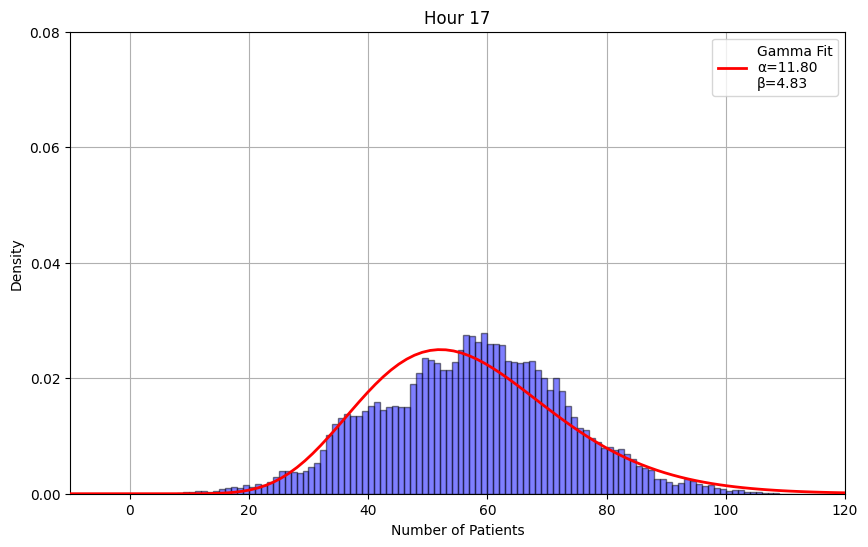

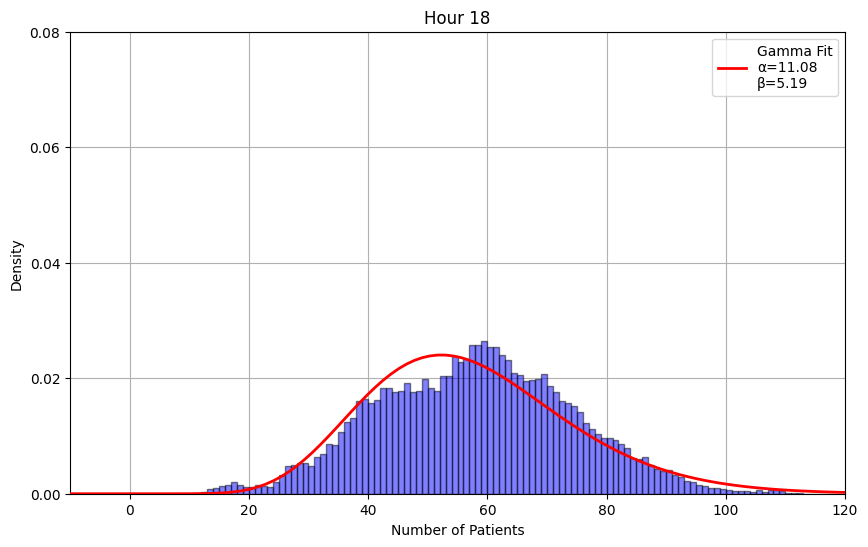

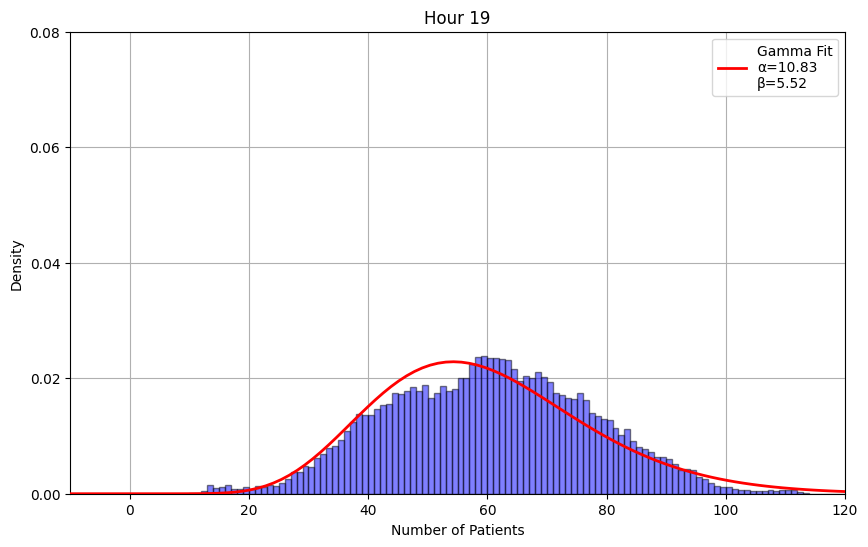

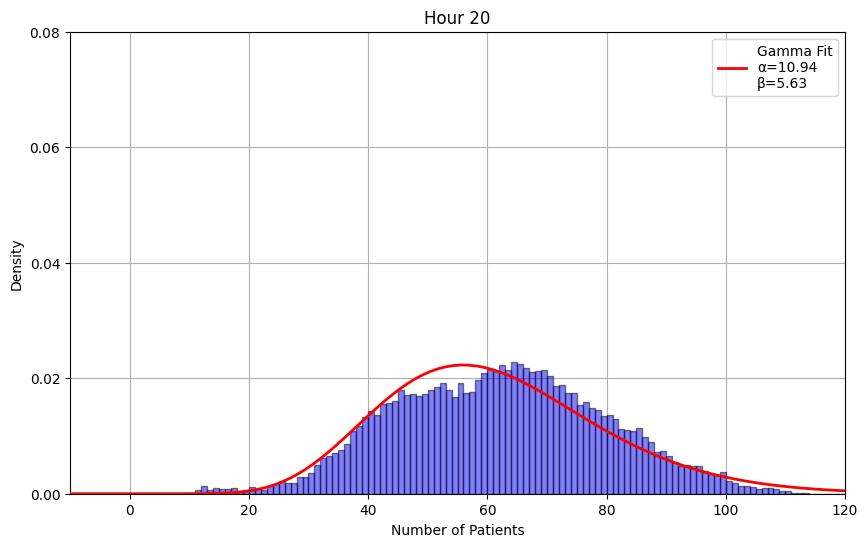

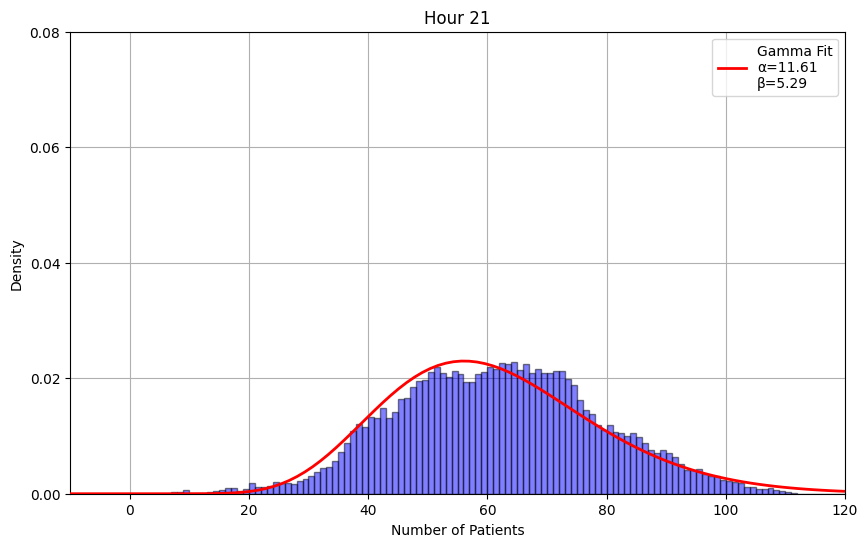

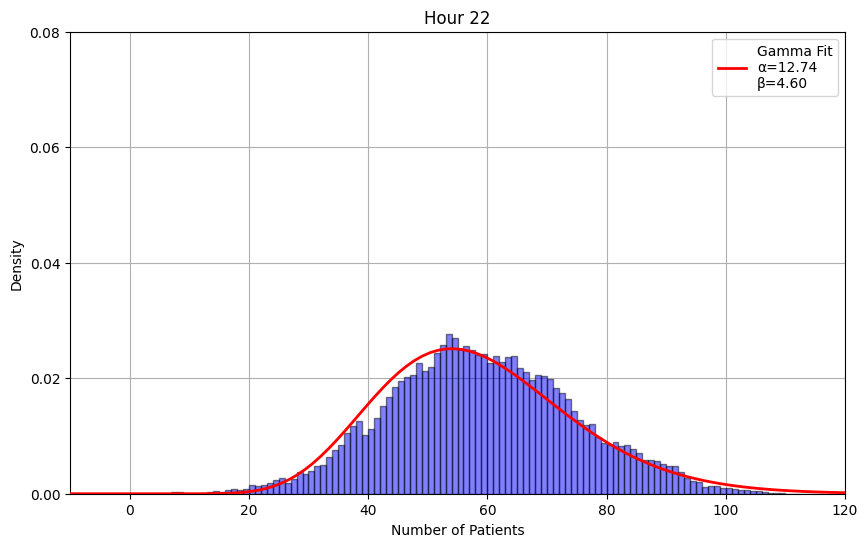

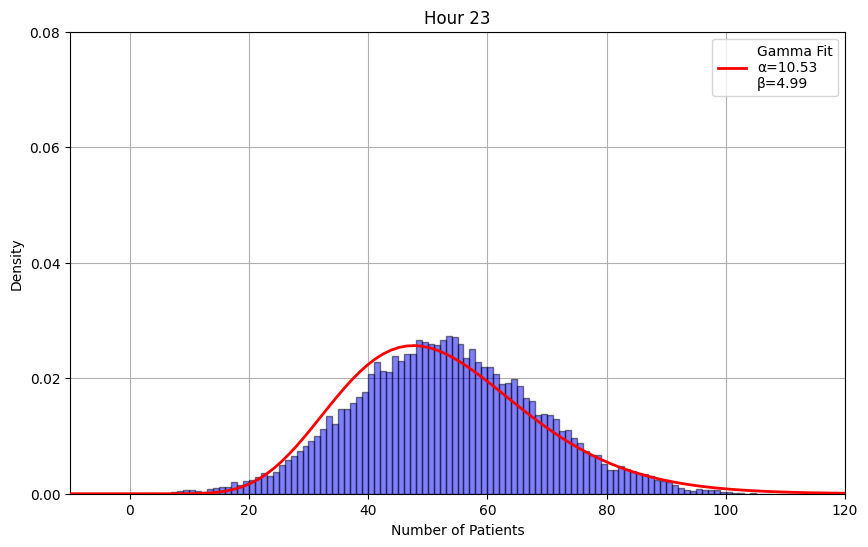

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

# Initialize lists to hold alpha and beta parameters for each hour
alpha_params = []
beta_params = []

# Set extended x-axis limits
x_min, x_max = -10, 120  # Adjusted range to zoom out
y_min, y_max = 0, 0.08
y_ticks = np.arange(y_min, y_max + 0.02, 0.02)

for hour in range(24):
    # Access data for the current hour
    hourly_data = np.array(hourly_minutes[str(hour)])  # Convert list to NumPy array
    hourly_data = hourly_data[hourly_data > 0]  # Remove zero and negative values

    # Create a new figure for each hour
    plt.figure(figsize=(10, 6))

    if len(hourly_data) > 10:  # Ensure sufficient data for fitting
        # Fit gamma distribution
        alpha, loc, beta = gamma.fit(hourly_data, floc=0)
        alpha_params.append(alpha)
        beta_params.append(beta)

        # Plot histogram
        counts, bins, _ = plt.hist(hourly_data, bins=np.arange(x_min, x_max + 1, 1), density=True, alpha=0.5, color='blue', edgecolor='black', zorder=2)

        # Plot fitted gamma distribution
        x = np.linspace(x_min, x_max, 100)
        y = gamma.pdf(x, alpha, loc, beta)
        plt.plot(x, y, 'r-', lw=2, label=f'Gamma Fit\nα={alpha:.2f}\nβ={beta:.2f}', zorder=3)
        plt.legend(loc='upper right')  # Add legend to the plot
    else:
        # Append NaN for hours with insufficient data
        alpha_params.append(np.nan)
        beta_params.append(np.nan)

    # Set plot limits and labels
    plt.xlim([x_min, x_max])  # Set extended x-axis limits
    plt.ylim([y_min, y_max])
    plt.yticks(y_ticks)
    plt.grid(True, zorder=0)
    plt.title(f'Hour {hour}')
    plt.xlabel('Number of Patients')
    plt.ylabel('Density')

    plt.show()
